In [2]:
import sys, os, time
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
from astropy.io import fits
from flat_sky_codes import tangent_plane_analysis as tpa
from modules.settings import global_mmf_settings as gset
from simulate import cluster_templates as cltemp
from filters import modular_multi_matched_filter as mmf
from data_preprocess import preprocess_planck_data_cosmo_cat as ppd
from masking import gen_masks as gm
from data_preprocess import data_inpaint_ps as paint

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=True
numprocs=6

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.
    
mask_lfi=False

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False
figstamp,dir_suffix

('planck_pr3_hfi_masked_data', 'hfi_masked_data')

In [4]:
outpath="/results/" + dataset + "//" + whichch + "/"
tempdatapath="/tempdata/" + dataset + "/planck_esz_cat/"
gset.setup_mmf_config(dataset="planck_pr1",outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=5.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]

if mask_lfi:
    gset.mmfset.ps_mask_weights[30.]=1.
    gset.mmfset.ps_mask_weights[44.]=1.
    gset.mmfset.ps_mask_weights[70.]=1.

In [5]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=40.,T_step=0.1,theta500_min=2.,theta500_max=50.,theta_step=4.)
tmplt.setup_templates()

In [6]:
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [8]:
coma_lon=58.0791 ; coma_lat=87.9577
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,coma_lat,coma_lon,rescale=1.)

# lon=58.0791 ; lat=37.9577
# projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,lat,lon,rescale=1.)

# lon=28.0791 ; lat=67.9577
# projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,lat,lon,rescale=1.)
# virgo_lon=279.6763 ; virgo_lat=74.4596
# projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,virgo_lat,virgo_lon,rescale=1.)

In [30]:
data=np.zeros((np.size(gset.mmfset.channels),gset.mmfset.npix,gset.mmfset.npix),float)
for ich,ch in enumerate(gset.mmfset.channels):
    chmap=h.read_map(gset.mmfset.map_fnames[ch],0,verbose=False)/gset.mmfset.conv_KCMB2MJY[ch]
    timage=projop.get_tangent_plane(chmap)
    data[ich,:,:]=timage

In [10]:
# ppd.gen_ps_mask(snrthr=10.,ps_cutoff=3.,verbose=False,gen_mask=True)

In [31]:
chmap=h.read_map(gset.mmfset.paths["planck_masks"] + "mmf3_ps_snr" + str(int(3)) + "_mask.fits",verbose=False)
psmask=projop.get_tangent_plane(chmap)
emask=gm.return_edge_apodized_mask(15.,20.)

chmap=h.read_map("/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits",verbose=False)
planck_ymap=projop.get_tangent_plane(chmap)

chmap=h.read_map("/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits",verbose=False)
planck_cmb=projop.get_tangent_plane(chmap)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [32]:
psf_data=np.zeros_like(data)
for ich, ch in enumerate(gset.mmfset.channels): 
    psf_data[ich,]=paint.return_ps_filled_data(data[ich,],psmask,pixel_size=gset.mmfset.reso,diffthr=1e-3,itermax=20)

<IPython.core.display.Javascript object>


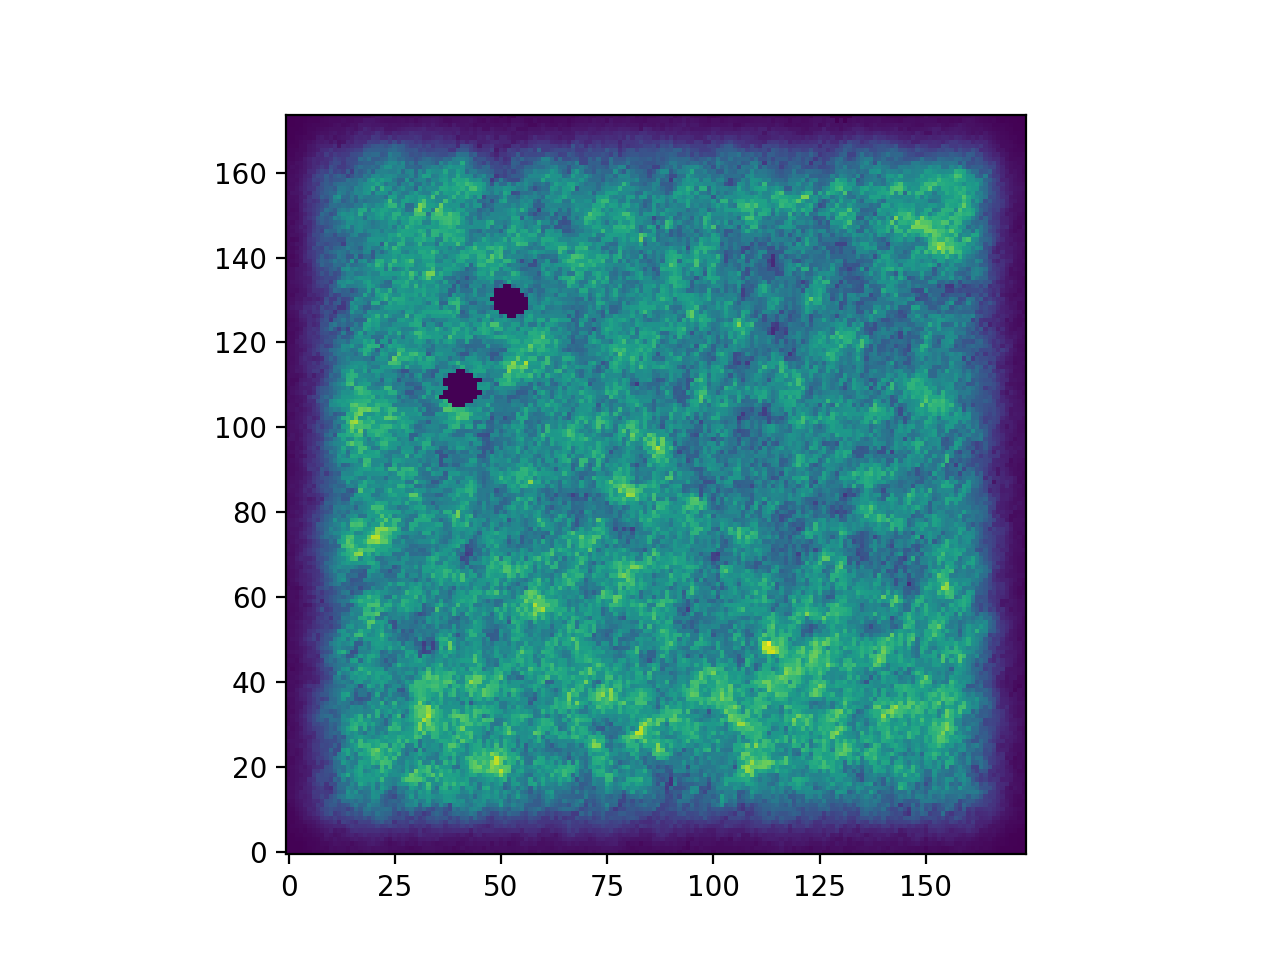

<IPython.core.display.Javascript object>


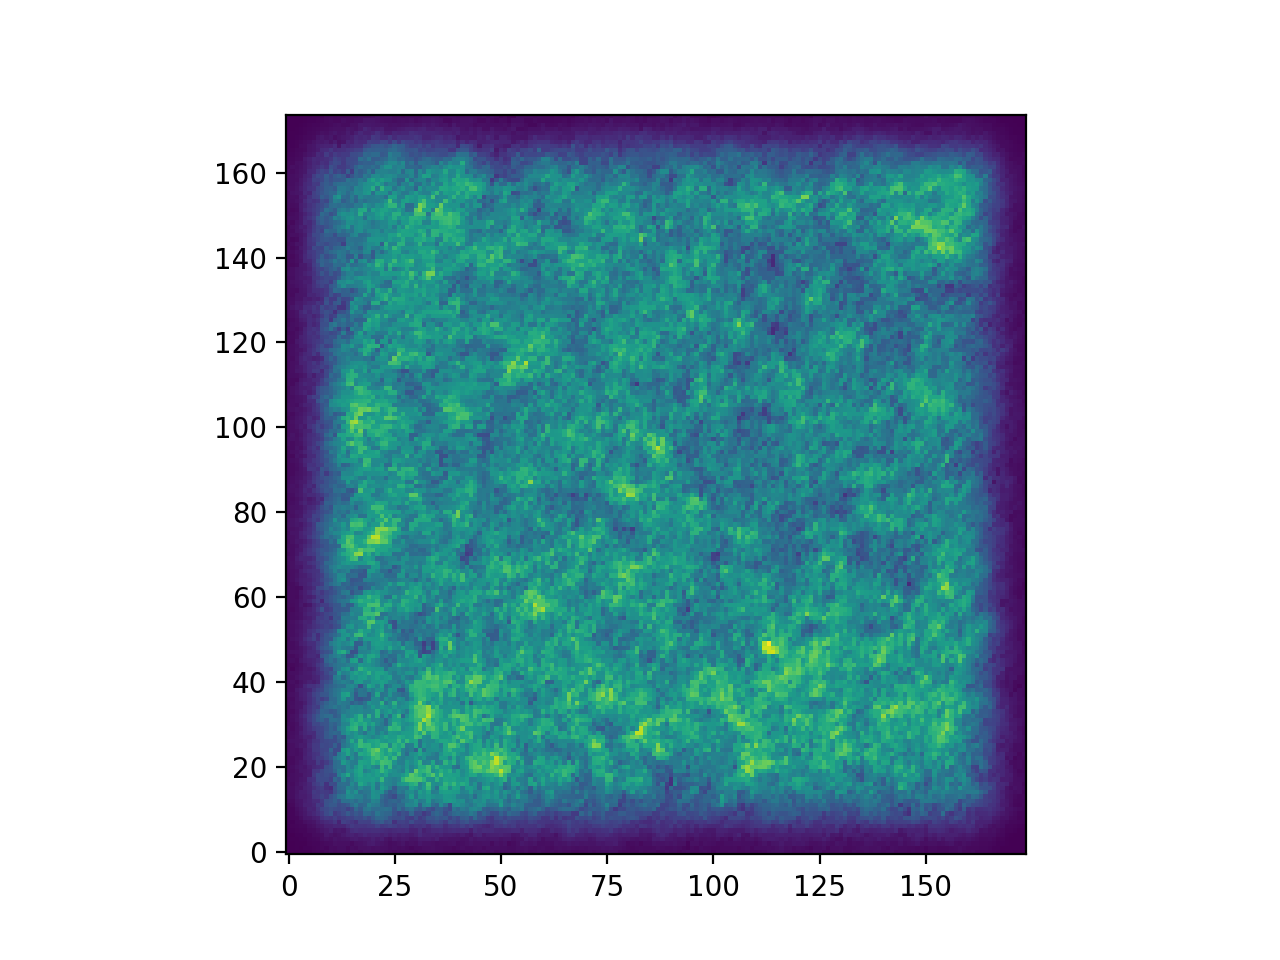

In [33]:
figure()
imshow(data[4,]*psmask*emask,origin="lower")

figure()
imshow(psf_data[4,]*emask,origin="lower")

In [34]:
op.get_data_ft(psf_data*psmask*emask,smwin=5)
fdata_ft=np.zeros_like(op.data_ft) ; fdata=np.zeros_like(data)
from flat_sky_codes import flat_sky_analysis as fsa
lmax=4*gset.mmfset.nside
ellp,smbl=fsa.get_gauss_beam(0.,lmax=lmax)
smfiltr=fsa.get_fourier_filter(smbl,gset.mmfset.npix,gset.mmfset.reso,ell=ellp)

In [35]:
filtr={}
for ich, ch in enumerate(gset.mmfset.channels):
    if ch<100.:
        filtr[ch]=smfiltr/tmplt.chfiltr[ch]
        filtr[ch][tmplt.chfiltr[ch]<8e-2]=0.
    else:
        #filtr[ch]=smfiltr/tmplt.chfiltr[ch]
        filtr[ch]=1./tmplt.chfiltr[ch]
        
for ich, ch in enumerate(gset.mmfset.channels):
    fdata_ft[ich,:,:]=op.data_ft[ich,:,:]*filtr[ch]
#     fdata[ich,:,:]=fsa.alm2map(fdata_ft[ich,:,:],gset.mmfset.reso)

In [36]:
cross_Pk=np.zeros((op.totnpix,op.numch,op.numch),np.float64)
for i,ch in enumerate(gset.mmfset.channels):
    for j in range(i+1):
        ell,cl=fsa.alm2cl(alm=fdata_ft[i,],almp=fdata_ft[j,],pixel_size=gset.mmfset.reso,smwin=5)
        filtr=fsa.get_fourier_filter(cl,op.nxpix,gset.mmfset.reso,ell=ell)
        cross_Pk[:,i,j]=filtr.reshape(op.totnpix)
        cross_Pk[:,j,i]=cross_Pk[:,i,j]
cross_Pk_inv=np.linalg.inv(cross_Pk)

In [42]:
snu=np.zeros_like(tmplt.sz_spec_bank[0].values())
for ich,ch in enumerate(gset.mmfset.channels):
    snu[ich]=tmplt.sz_spec_bank[0.][ch]
temp_fdata_ft=fdata_ft.reshape(op.numch,op.totnpix)

# Standard ILC

In [52]:
ellp,smbl=fsa.get_gauss_beam(9.659,lmax=lmax)
smfiltr=fsa.get_fourier_filter(smbl,gset.mmfset.npix,gset.mmfset.reso,ell=ellp)
normk=np.einsum("i,kij,j->k",snu,cross_Pk_inv,snu)
fdata_ilc=np.einsum("i,kij,jk->k",snu,cross_Pk_inv,temp_fdata_ft)*smfiltr.reshape(op.totnpix)/normk
ymap_ilc=fsa.alm2map(fdata_ilc.reshape(op.nxpix,op.nxpix),gset.mmfset.reso)

<IPython.core.display.Javascript object>


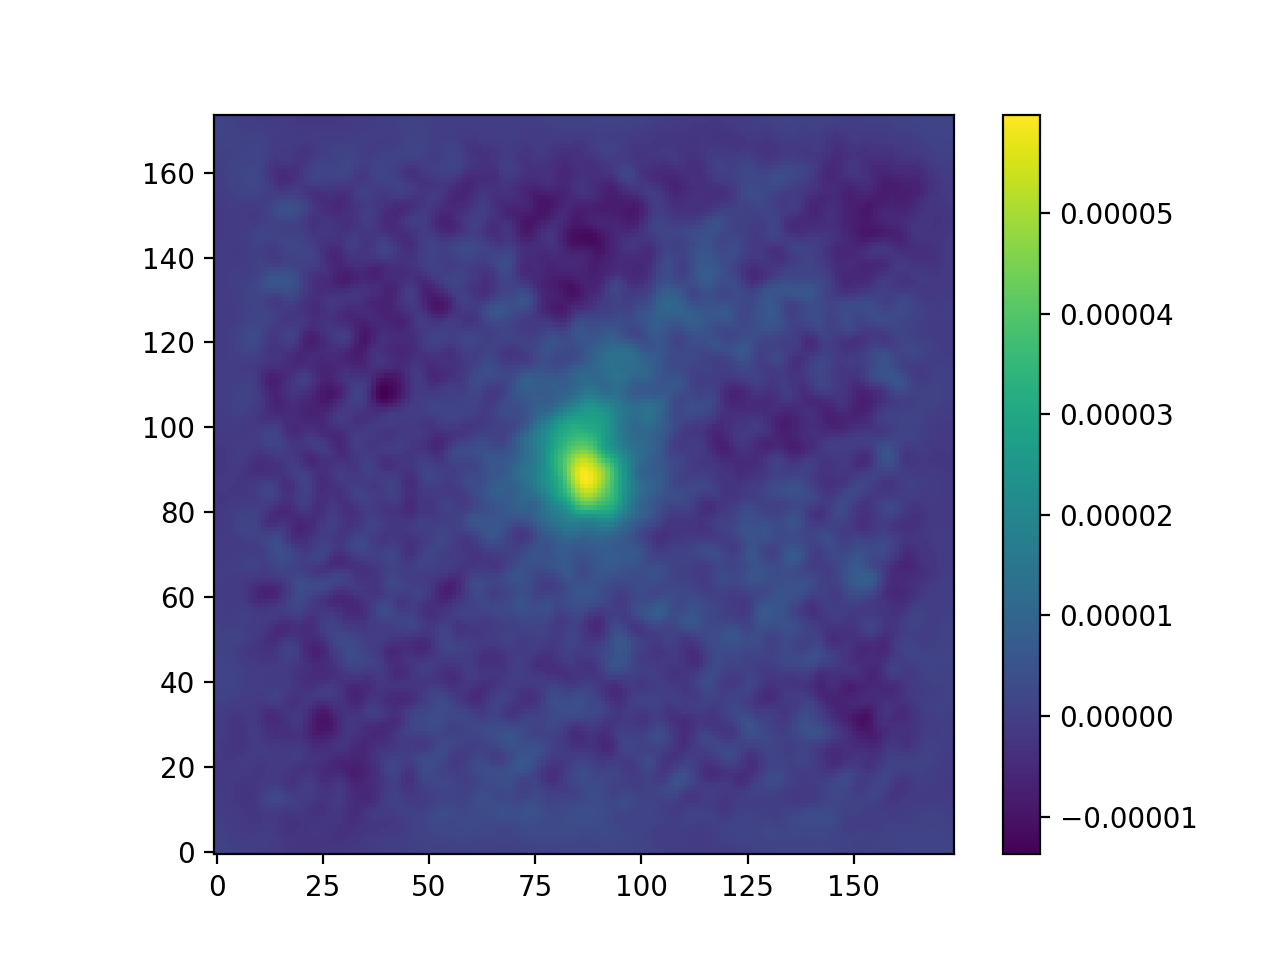

<IPython.core.display.Javascript object>


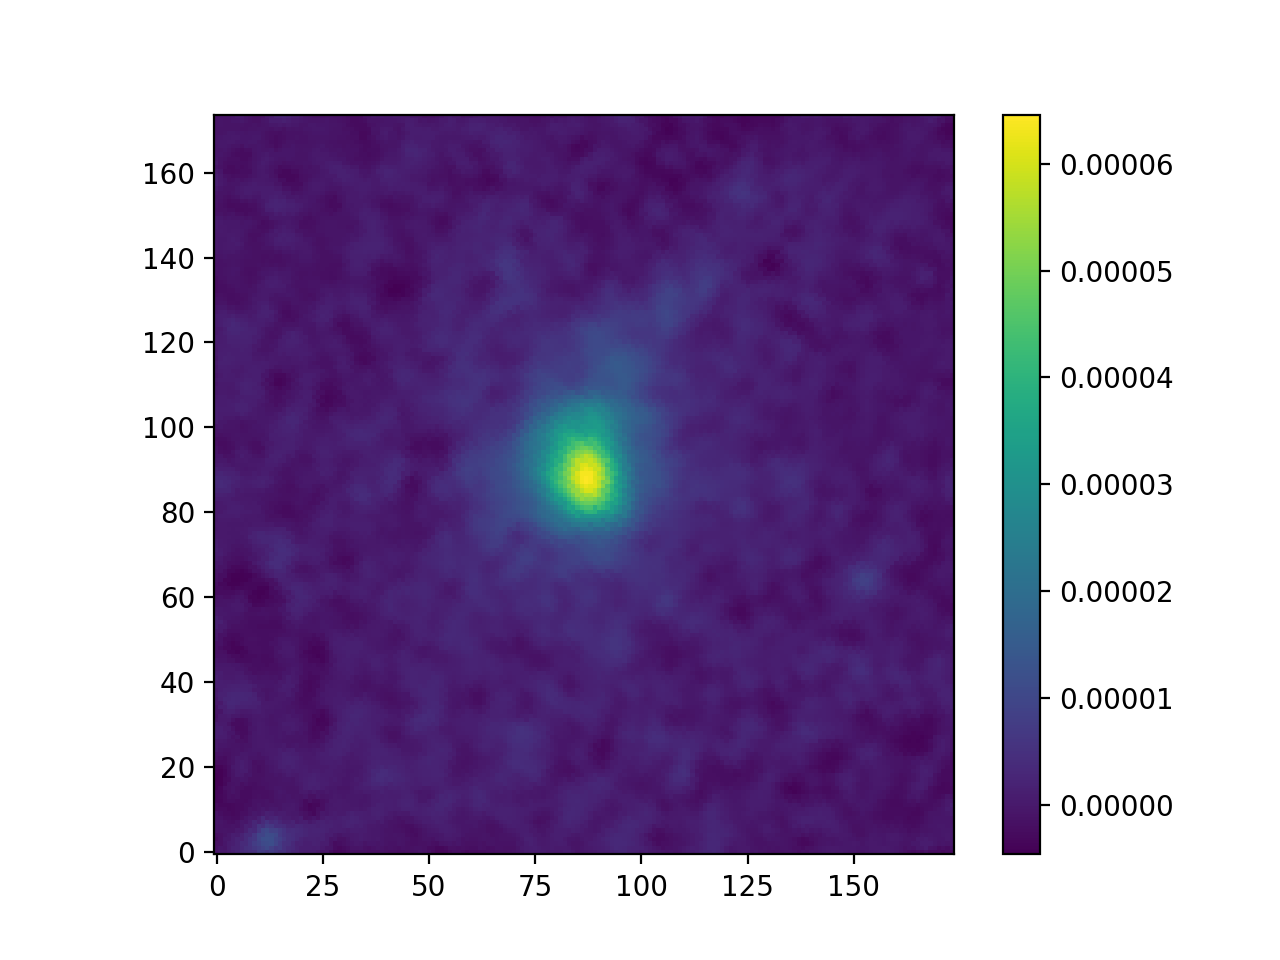

In [54]:
figure()
imshow(ymap_ilc,origin="lower")
colorbar()

figure()
imshow(planck_ymap,origin="lower")
colorbar()

# Constrained ILC

In [63]:
for ich,ch in enumerate(gset.mmfset.channels):
    snu[ich]=tmplt.sz_spec_bank[0.][ch]
    
bnu=np.ones_like(snu)
V=np.array([snu,bnu])
e=np.zeros(V.shape[0]) ; e[0]=1.
ellp,smbl=fsa.get_gauss_beam(9.7,lmax=lmax)
smfiltr=fsa.get_fourier_filter(smbl,gset.mmfset.npix,gset.mmfset.reso,ell=ellp)

In [64]:
C=np.einsum("qi,kij,nj->kqn",V,cross_Pk_inv,V)
Cinv=np.linalg.inv(C)
fil_fdata=np.einsum("qi,kij,jk->qk",V,cross_Pk_inv,temp_fdata_ft)
yft=(np.einsum("i,kij,jk->k",e,Cinv,fil_fdata)*smfiltr.reshape(op.totnpix)).reshape(op.nxpix,op.nxpix)
ymap_cilc=fsa.alm2map(yft,gset.mmfset.reso)

In [149]:
bnu

array([ 1.,  1.,  1.,  1.,  1.,  1.])

## Solving for all components with SED in matrix V

In [79]:
fil_fdata=np.einsum("qi,kij,jk->qk",V,cross_Pk_inv,temp_fdata_ft)
comp=["sz","cmb"] ; rec_fdata={} ; rec_data={}
dft=(np.einsum("kij,jk->ki",Cinv,fil_fdata)).reshape(op.nxpix,op.nxpix,V.shape[0])

for i,cmp in enumerate(comp):
    rec_fdata[cmp]=dft[:,:,i]*smfiltr
    rec_data[cmp]=fsa.alm2map(rec_fdata[cmp],gset.mmfset.reso)

<IPython.core.display.Javascript object>


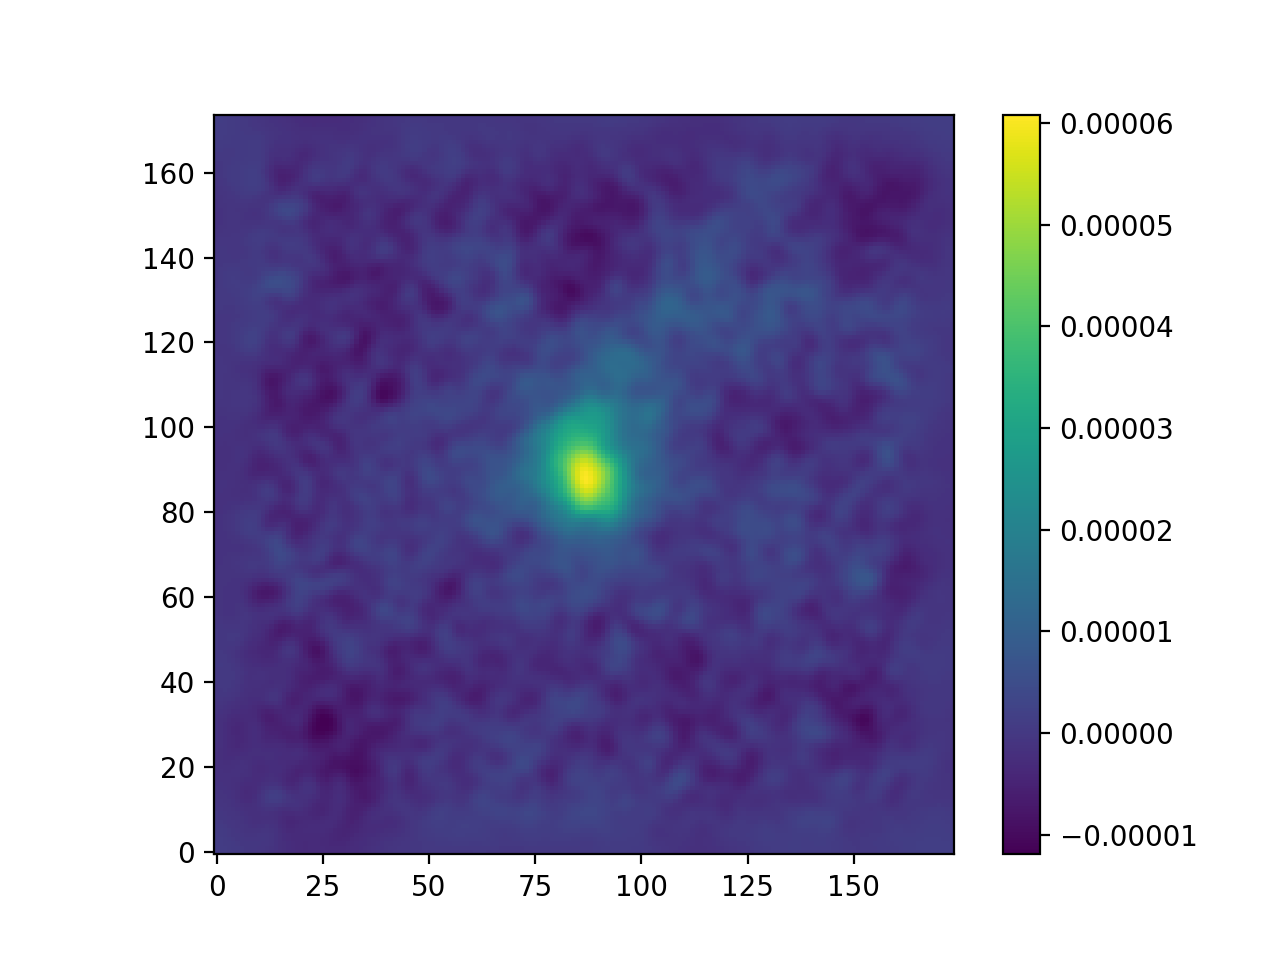

<IPython.core.display.Javascript object>


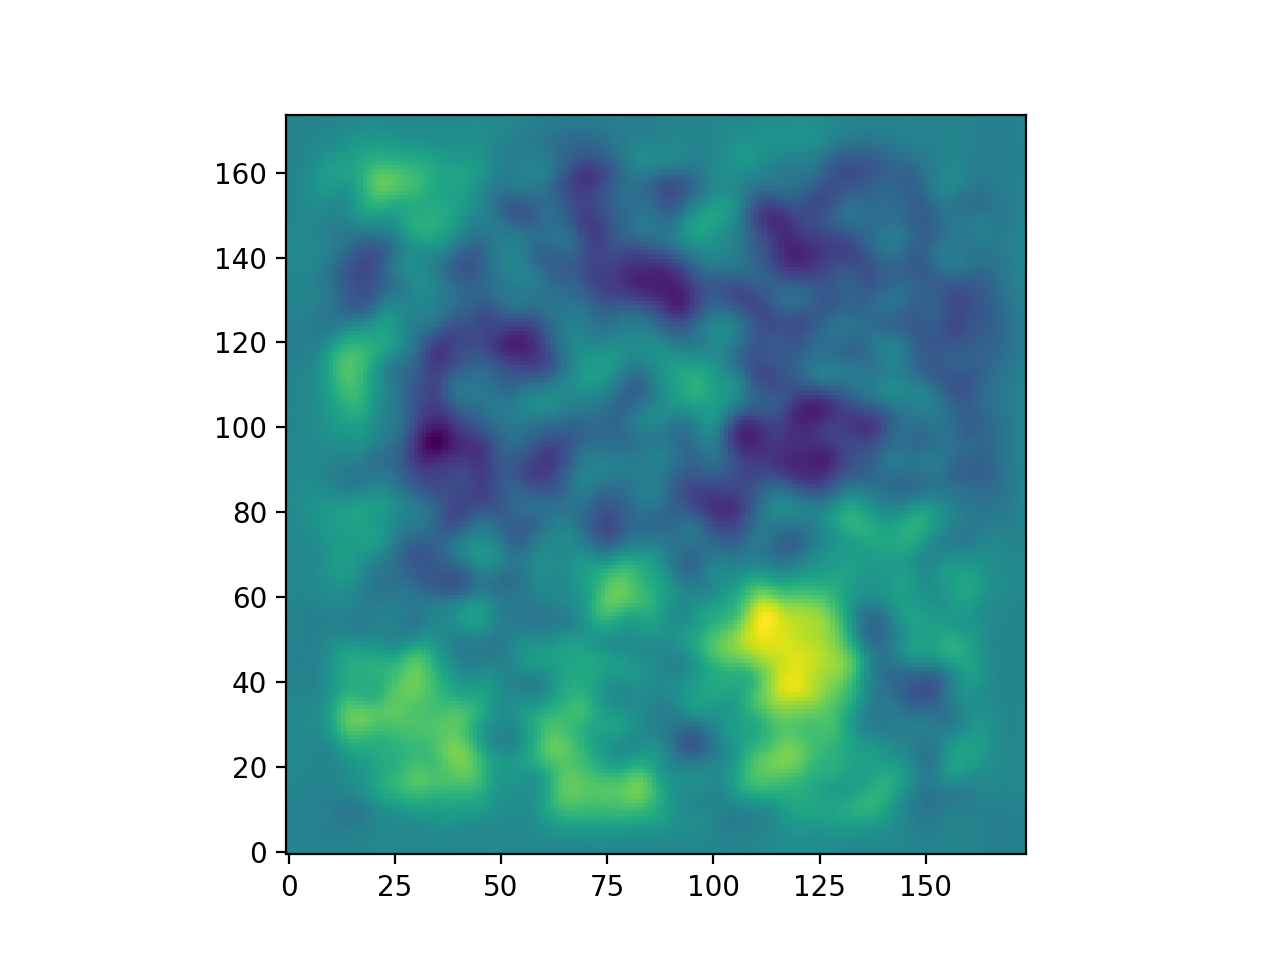

In [81]:
figure()
imshow(rec_data["sz"],origin="lower")
colorbar()

figure()
imshow(rec_data["cmb"],origin="lower")

<IPython.core.display.Javascript object>


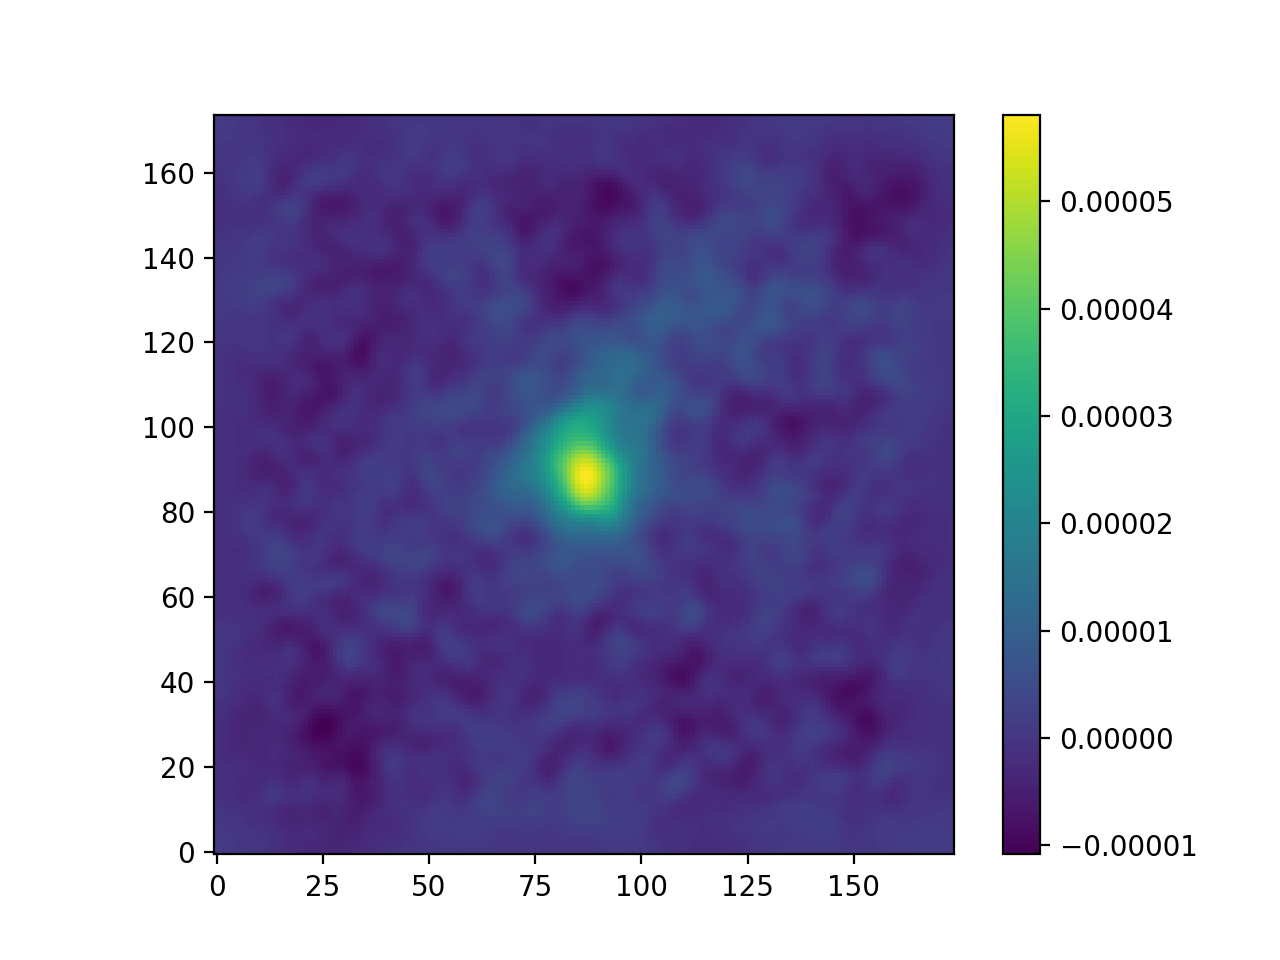

<IPython.core.display.Javascript object>


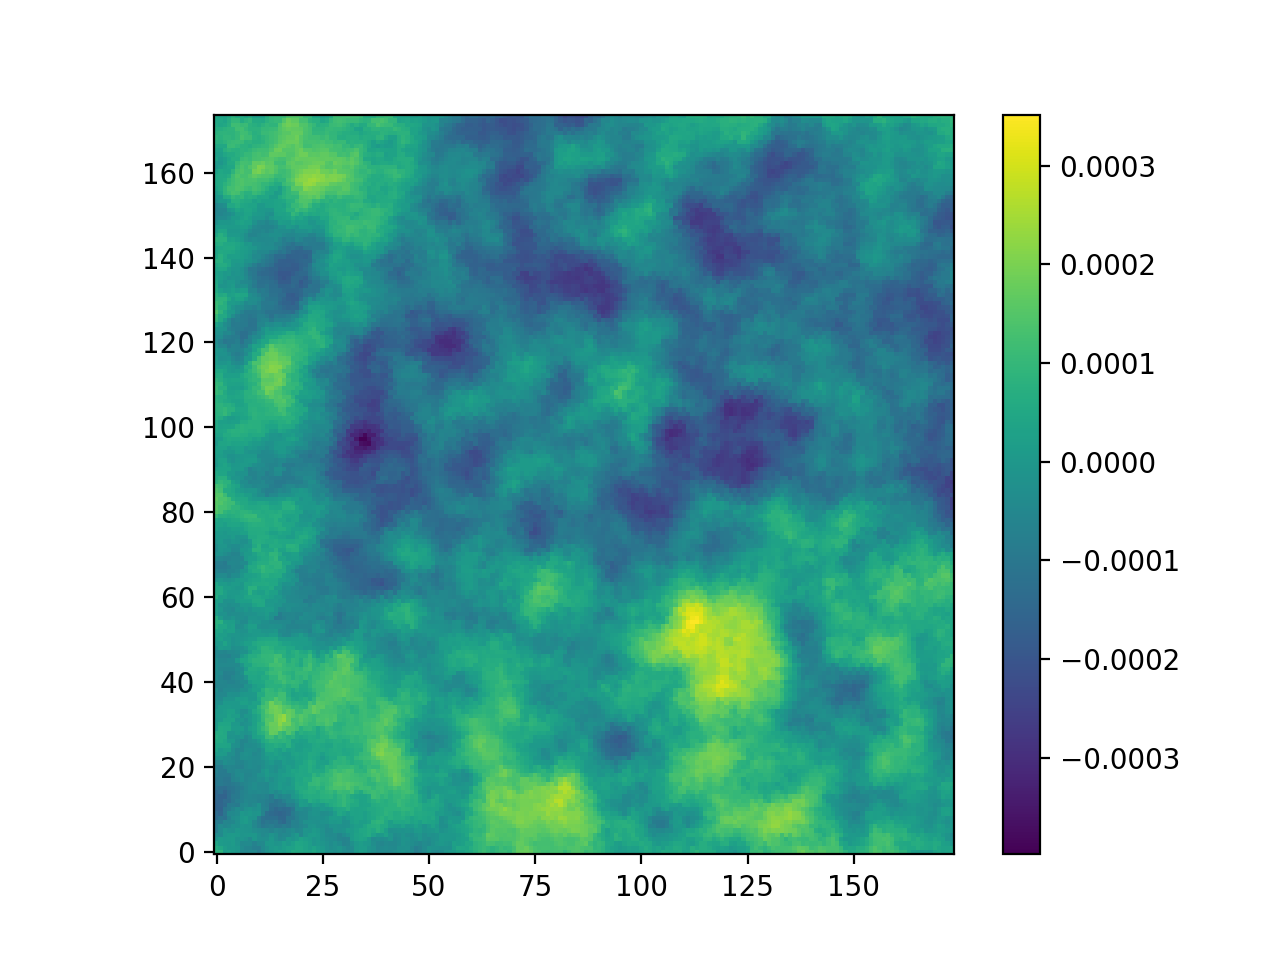

<IPython.core.display.Javascript object>


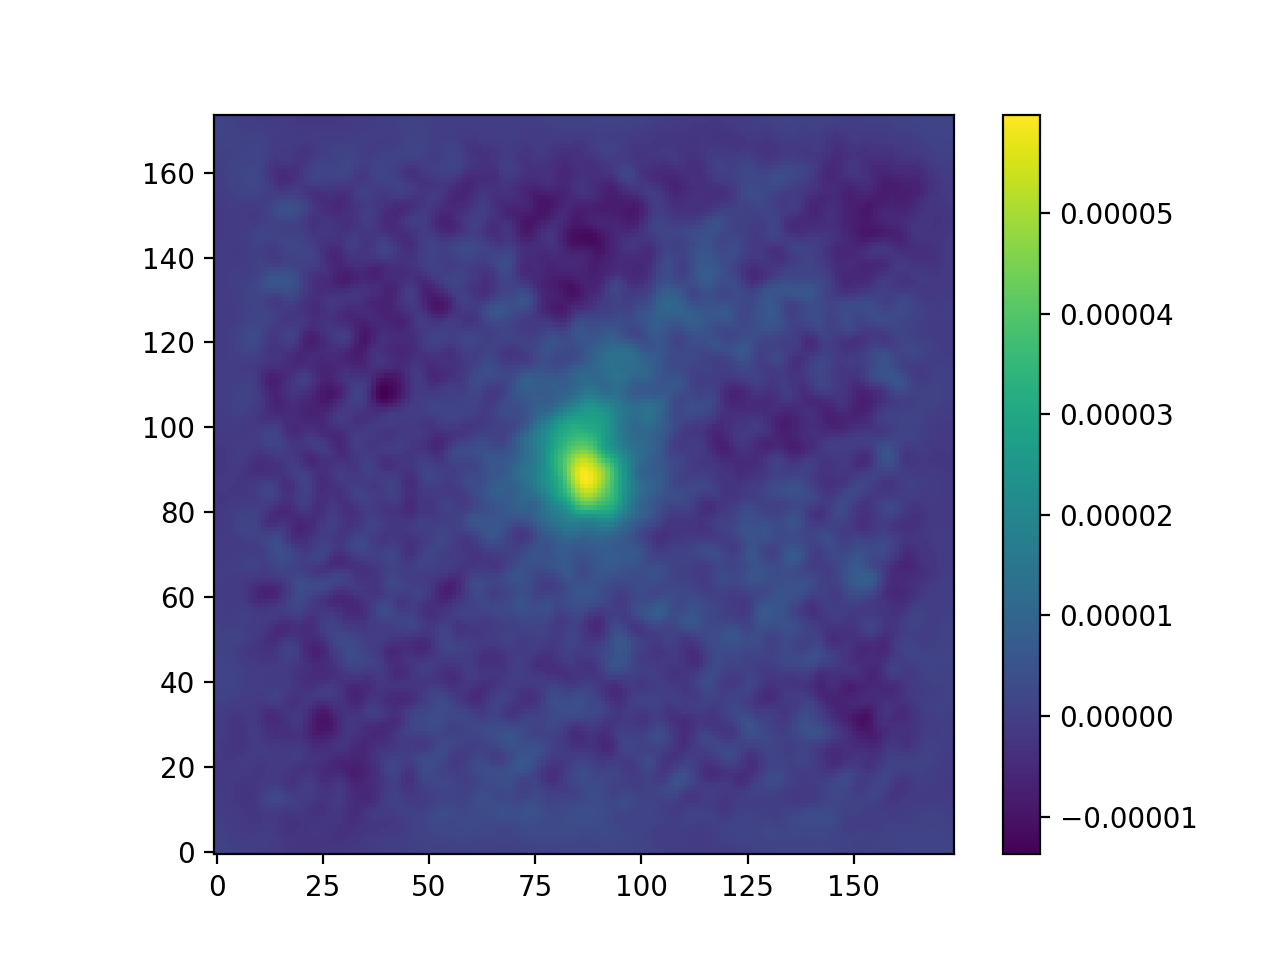

<IPython.core.display.Javascript object>


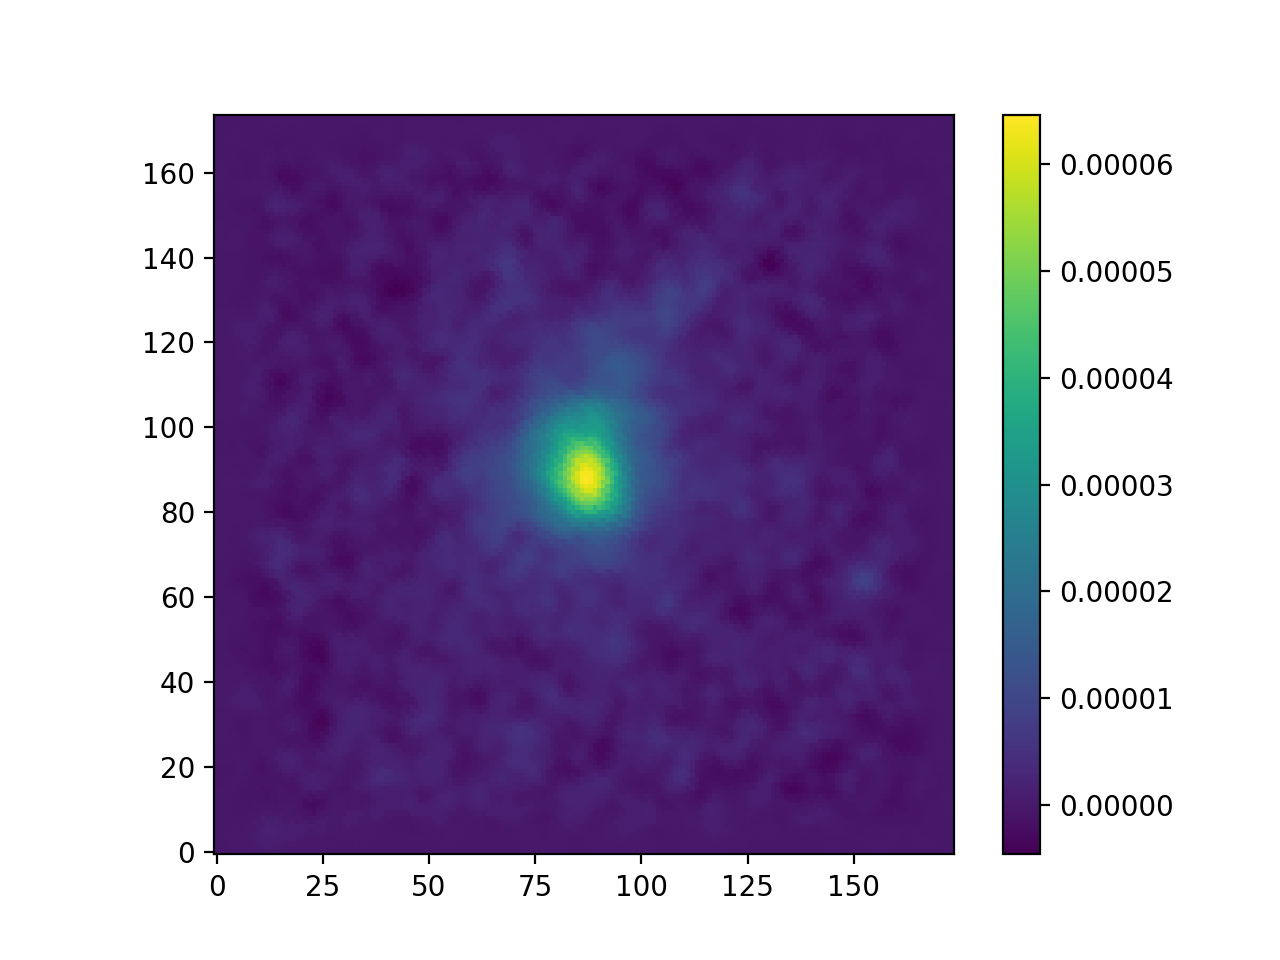

In [1173]:
figure()
imshow(ymap_cilc,origin="lower")
colorbar()

figure()
imshow(planck_cmb,origin="lower")
colorbar()

figure()
imshow(ymap_ilc,origin="lower")
colorbar()

figure()
imshow(planck_ymap*emask,origin="lower")
colorbar()

<IPython.core.display.Javascript object>


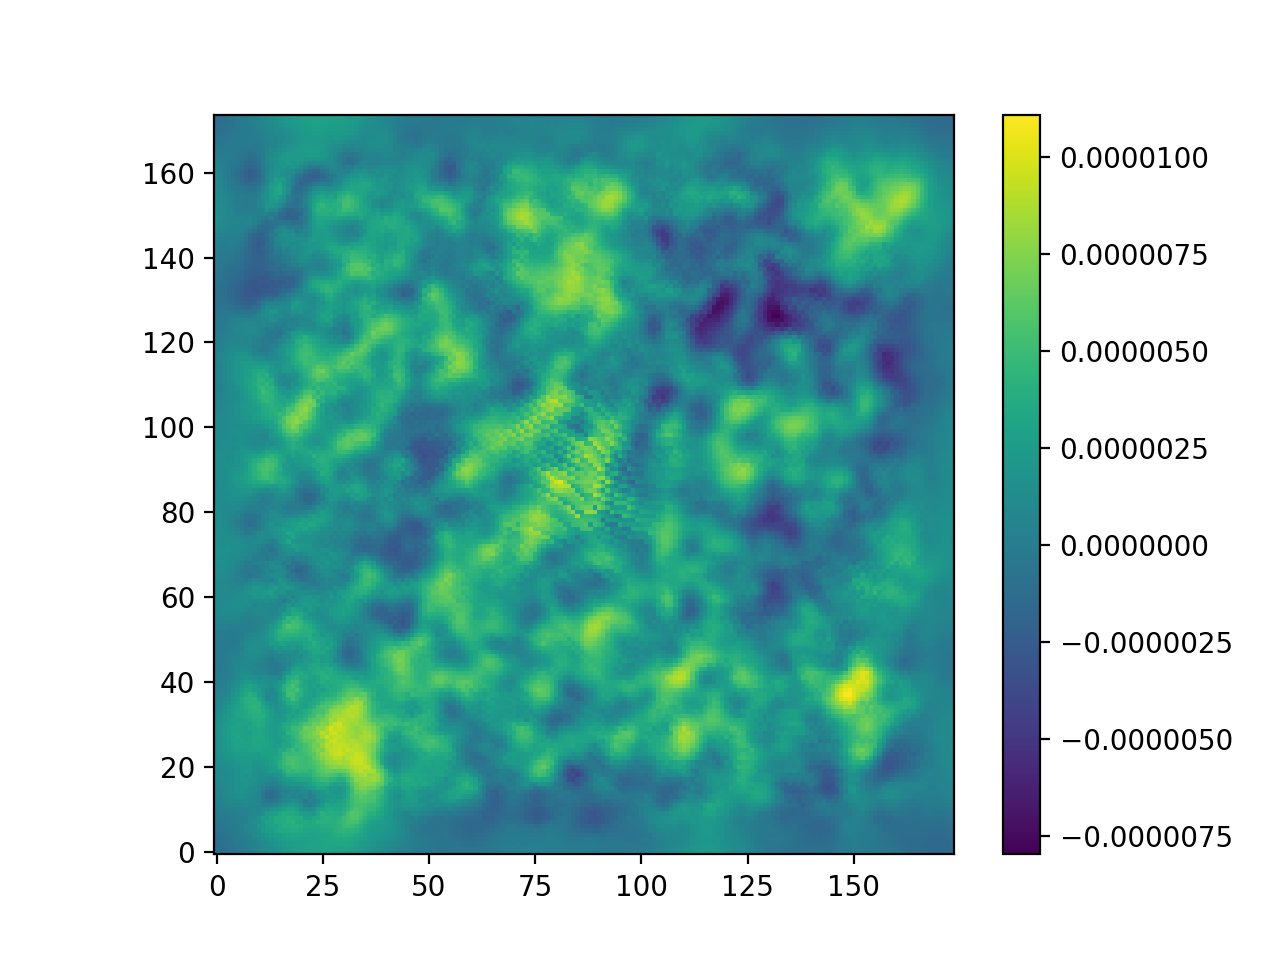

<IPython.core.display.Javascript object>


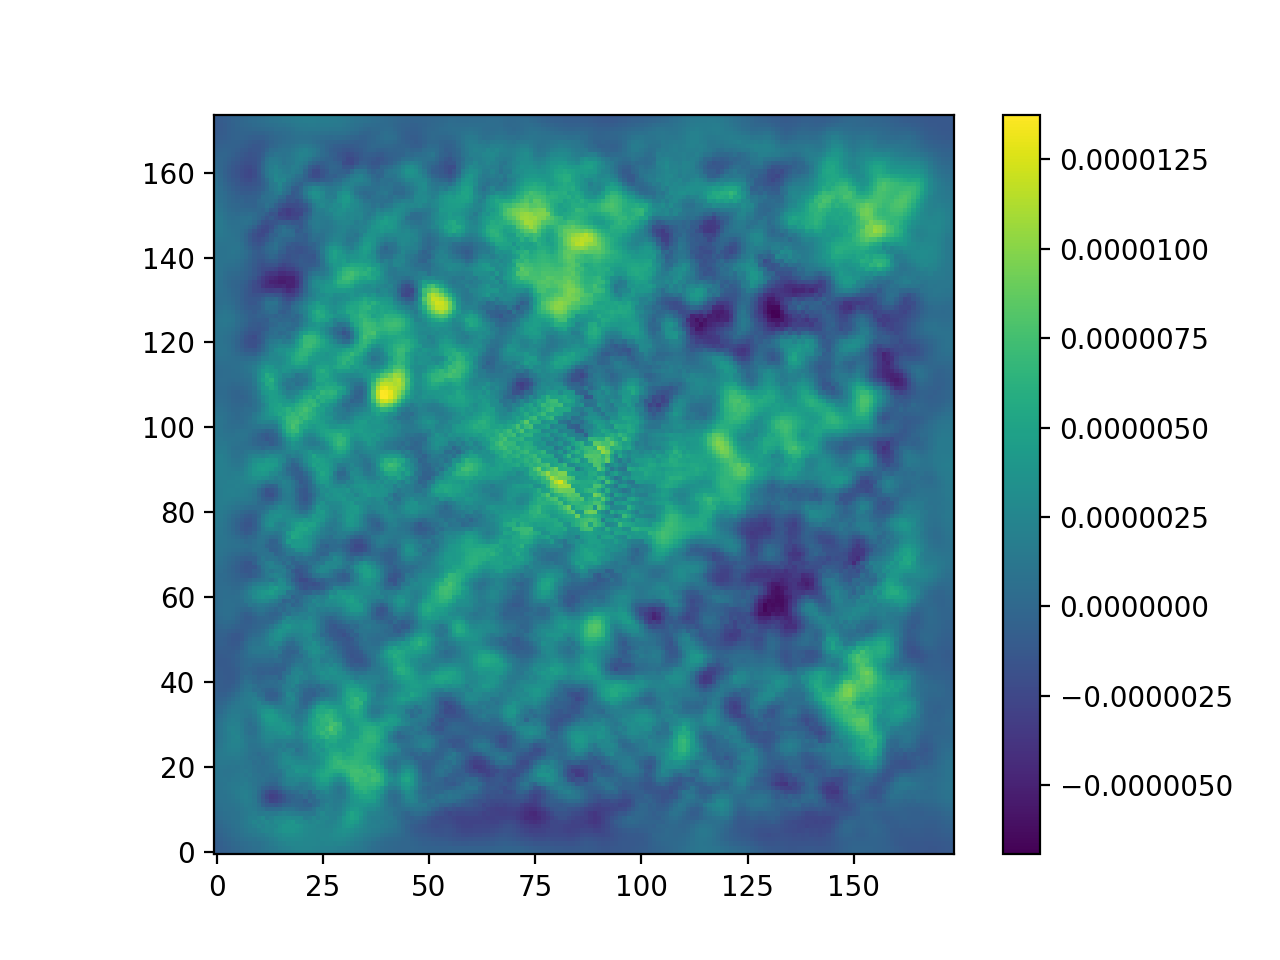

<IPython.core.display.Javascript object>


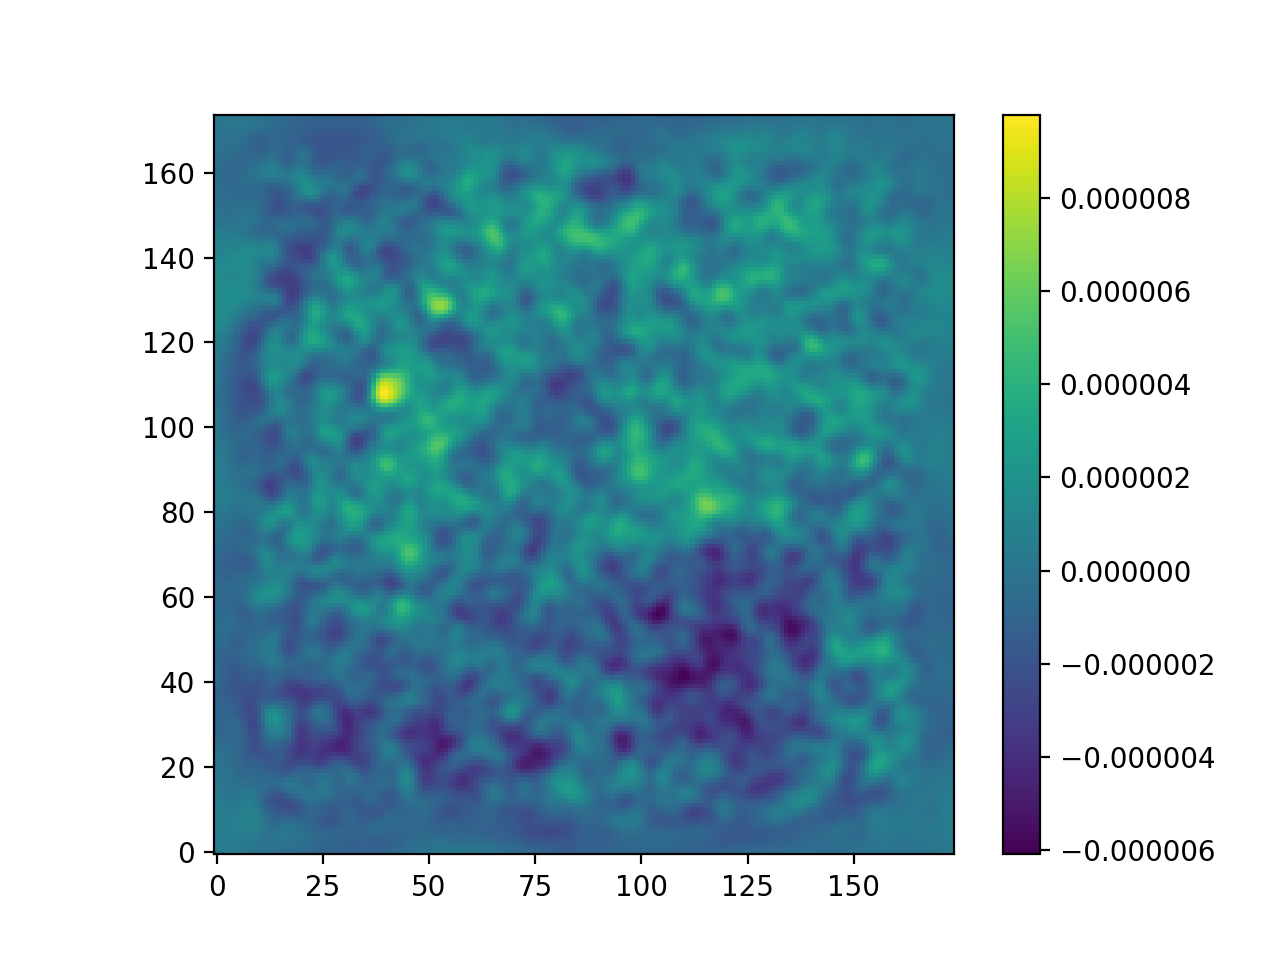

In [1174]:
figure()
imshow(planck_ymap*emask-ymap_cilc,origin="lower")
colorbar()


figure()
imshow(planck_ymap*emask - ymap_ilc,origin="lower")
colorbar()

figure()
imshow(ymap_cilc-ymap_ilc,origin="lower")
colorbar()

# Standard Multi Matched Filter

In [105]:
template_ft=np.zeros((op.totnpix,op.numch),np.complex)
template_ft2=np.zeros((op.totnpix,op.numch))
temp_data_ft=np.zeros((op.totnpix,op.numch),np.complex128)
for ich,ch in enumerate(gset.mmfset.channels):
    template_ft[:,ich]=(op.sp_ft_bank[30.0]*op.chfiltr[ch]).reshape(op.totnpix)
    temp_data_ft[:,ich]=op.data_ft[ich,].reshape(op.totnpix)

In [106]:
op.sp_ft_bank.keys()

[2.0, 50.0, 38.0, 6.0, 10.0, 34.0, 14.0, 18.0, 46.0, 22.0, 26.0, 42.0, 30.0]

In [107]:
snu=np.zeros_like(tmplt.sz_spec_bank[0].values())
for ich,ch in enumerate(gset.mmfset.channels):
    snu[ich]=tmplt.sz_spec_bank[0.][ch]

In [108]:
snu

array([ -4.03160086,  -2.78362028,   0.19252138,   6.20473171,
        14.45095604,  26.32486347])

In [109]:
norm_pq=np.real(np.einsum("ki,kij,kj->ij",template_ft,op.cross_Pk_inv,template_ft))*op.d2k
kf_data=np.einsum("ki,kij,kj->ki",template_ft,op.cross_Pk_inv,temp_data_ft)
ycft=np.einsum("i,ki->k",snu,kf_data).reshape(op.nxpix,op.nxpix)/np.einsum("i,ij,j",snu,norm_pq,snu)
yc=fsa.alm2map(ycft,gset.mmfset.reso)

In [110]:
np.sqrt(1./np.einsum("i,ij,j",snu,norm_pq,snu))

7.6189342483905607e-06

<IPython.core.display.Javascript object>


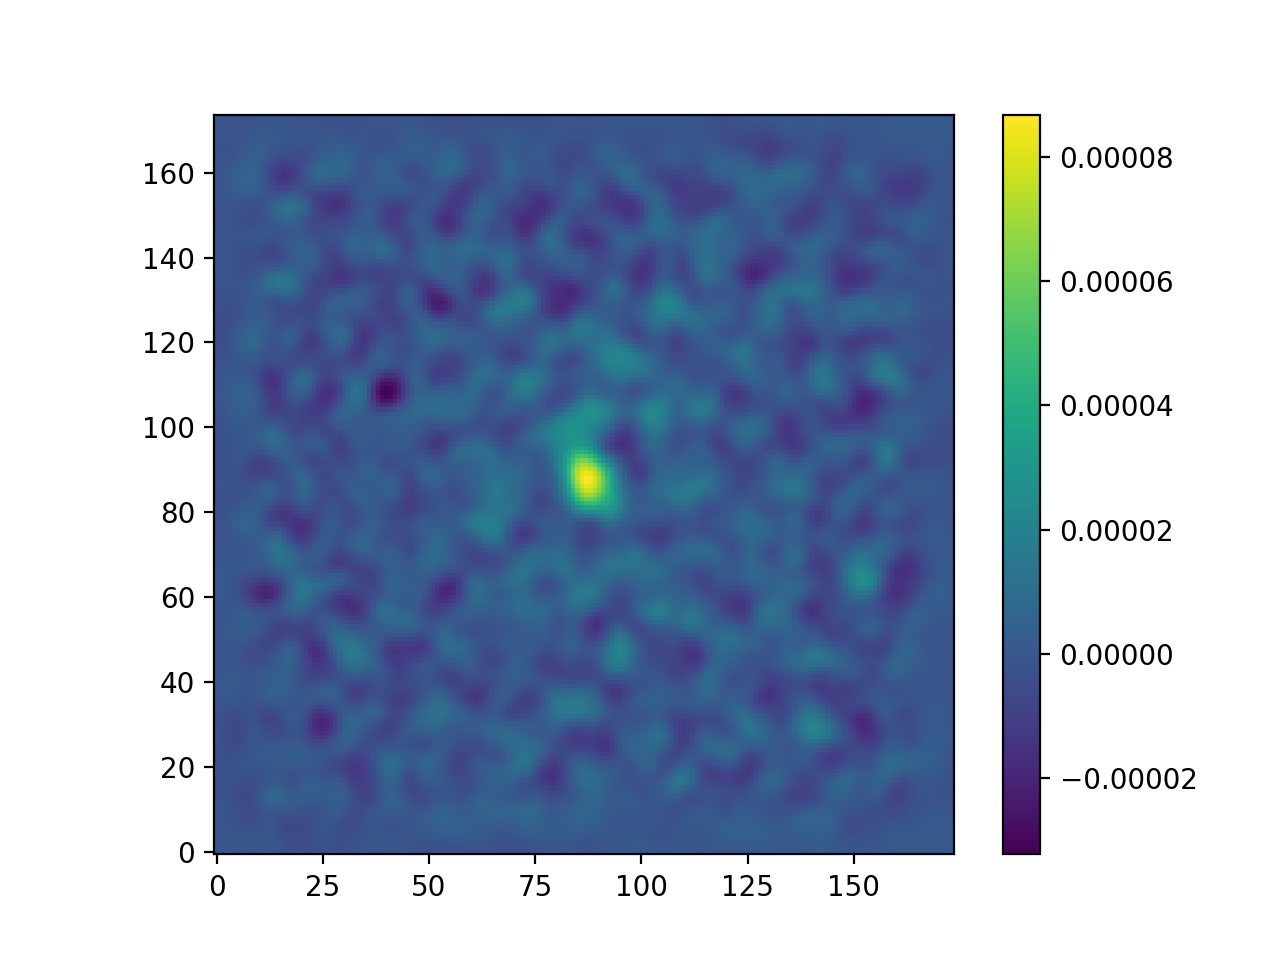

In [111]:
figure()
imshow(yc,origin="lower")
colorbar()

# Constrained Multi Matched Filter

In [113]:
bnu=np.ones_like(snu)
for ich,ch in enumerate(gset.mmfset.channels):
    snu[ich]=tmplt.sz_spec_bank[0.][ch]
    bnu[ich]=1.
    
V=np.array([snu,bnu])
e=np.zeros(V.shape[0]) ; e[0]=1.

C=np.einsum("ip,pq,jq->ij",V,norm_pq,V)
Cinv=np.linalg.inv(C)
kf_data1=np.einsum("pi,ki->kp",V,kf_data)
ycft=np.einsum("i,ij,kj->k",e,Cinv,kf_data1).reshape(op.nxpix,op.nxpix)
dft=np.einsum("ij,kj->ki",Cinv,kf_data1)
yc_cmmf=fsa.alm2map(ycft,gset.mmfset.reso)

In [117]:
print np.sqrt(1./np.einsum("i,ij,j",snu,norm_pq,snu))
print np.sqrt(Cinv[0,0])

7.61893424839e-06
7.62660261659e-06


In [1194]:
data_sz=fsa.alm2map((dft[:,0].reshape(op.nxpix,op.nxpix))*op.lpfiltr,gset.mmfset.reso)
data_cmb=fsa.alm2map((dft[:,1].reshape(op.nxpix,op.nxpix))*op.lpfiltr,gset.mmfset.reso)

<IPython.core.display.Javascript object>


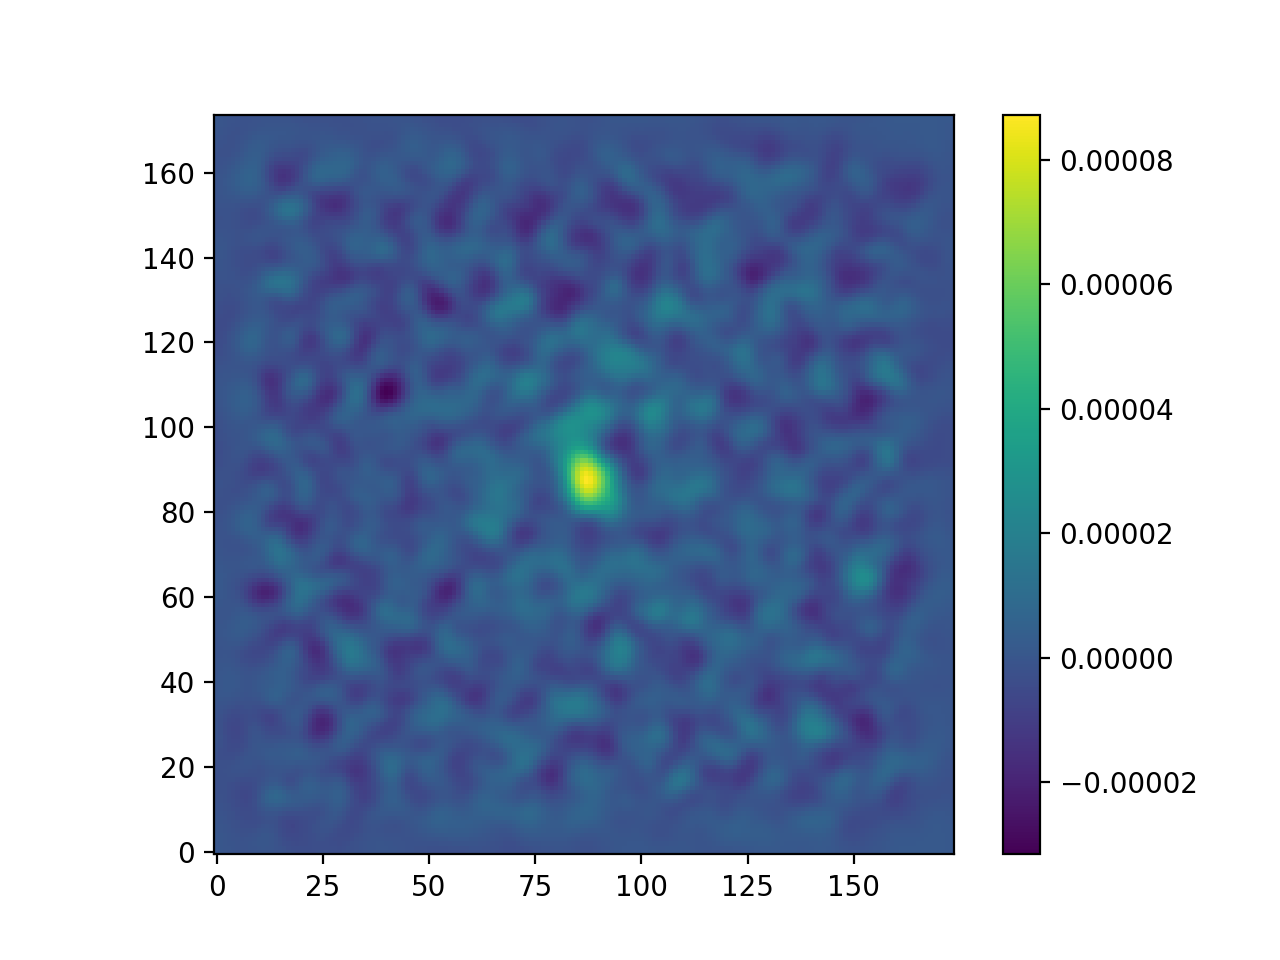

<IPython.core.display.Javascript object>


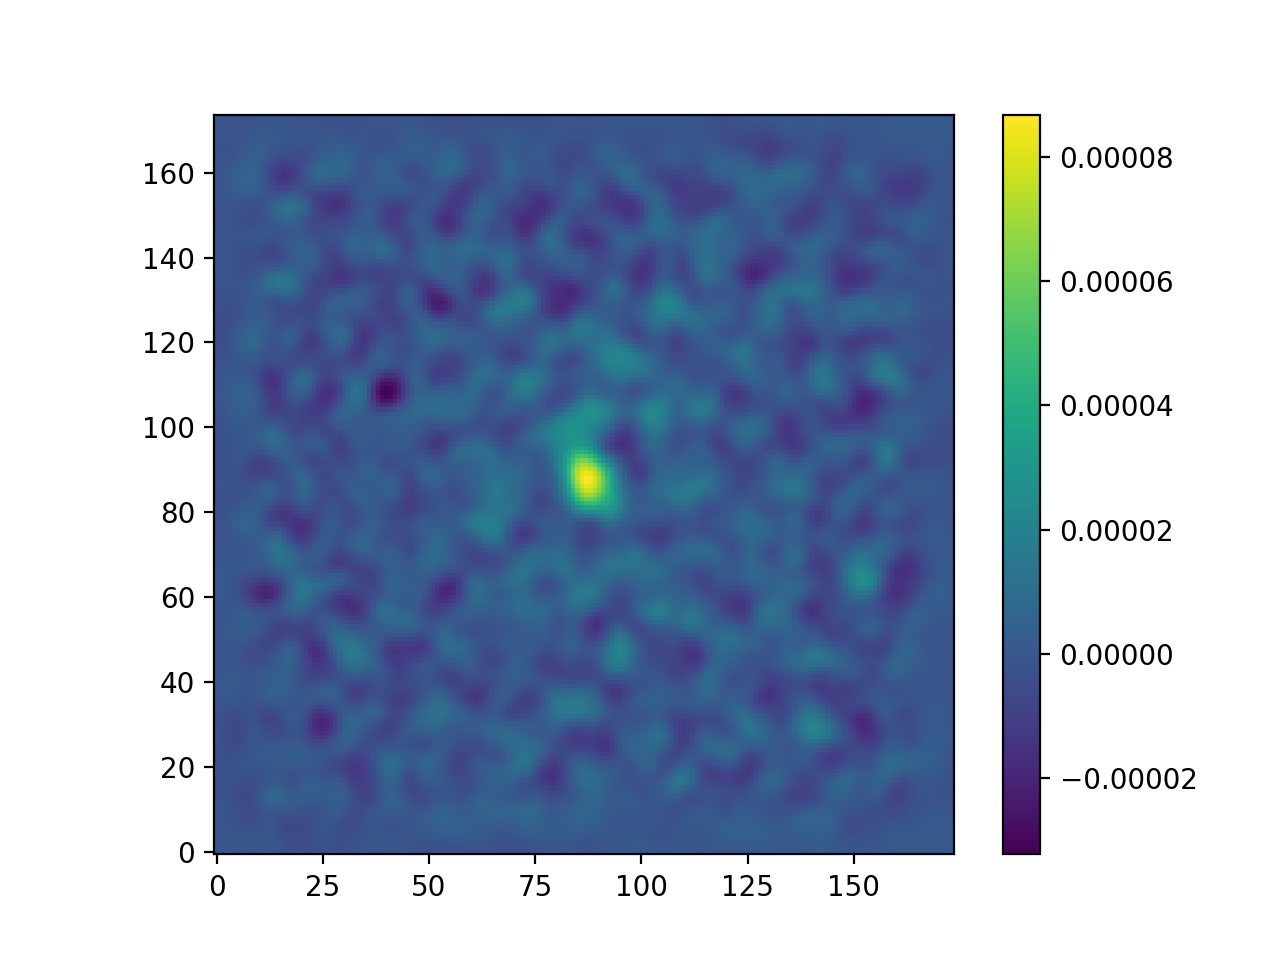

<IPython.core.display.Javascript object>


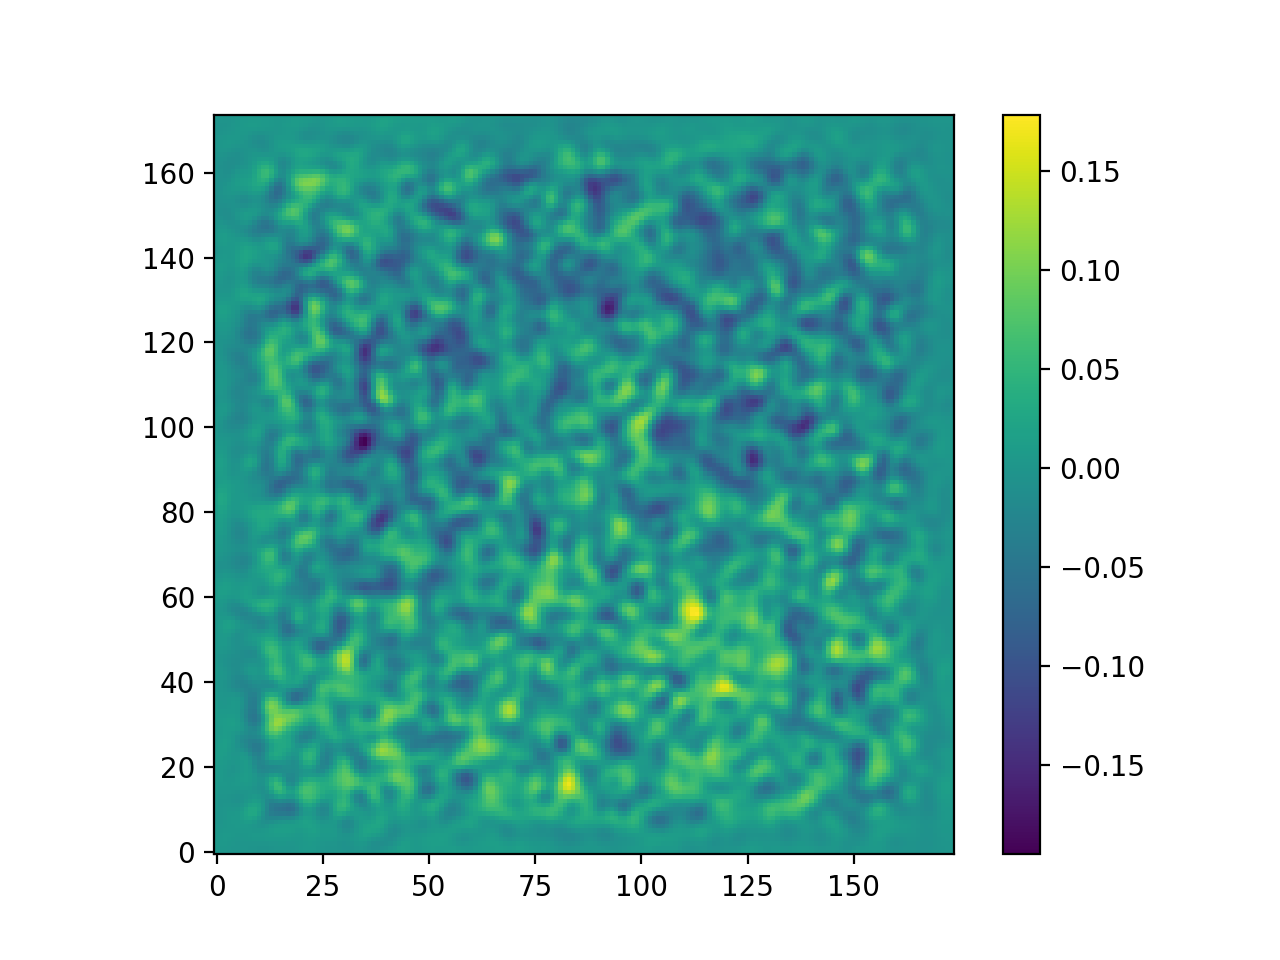

<IPython.core.display.Javascript object>


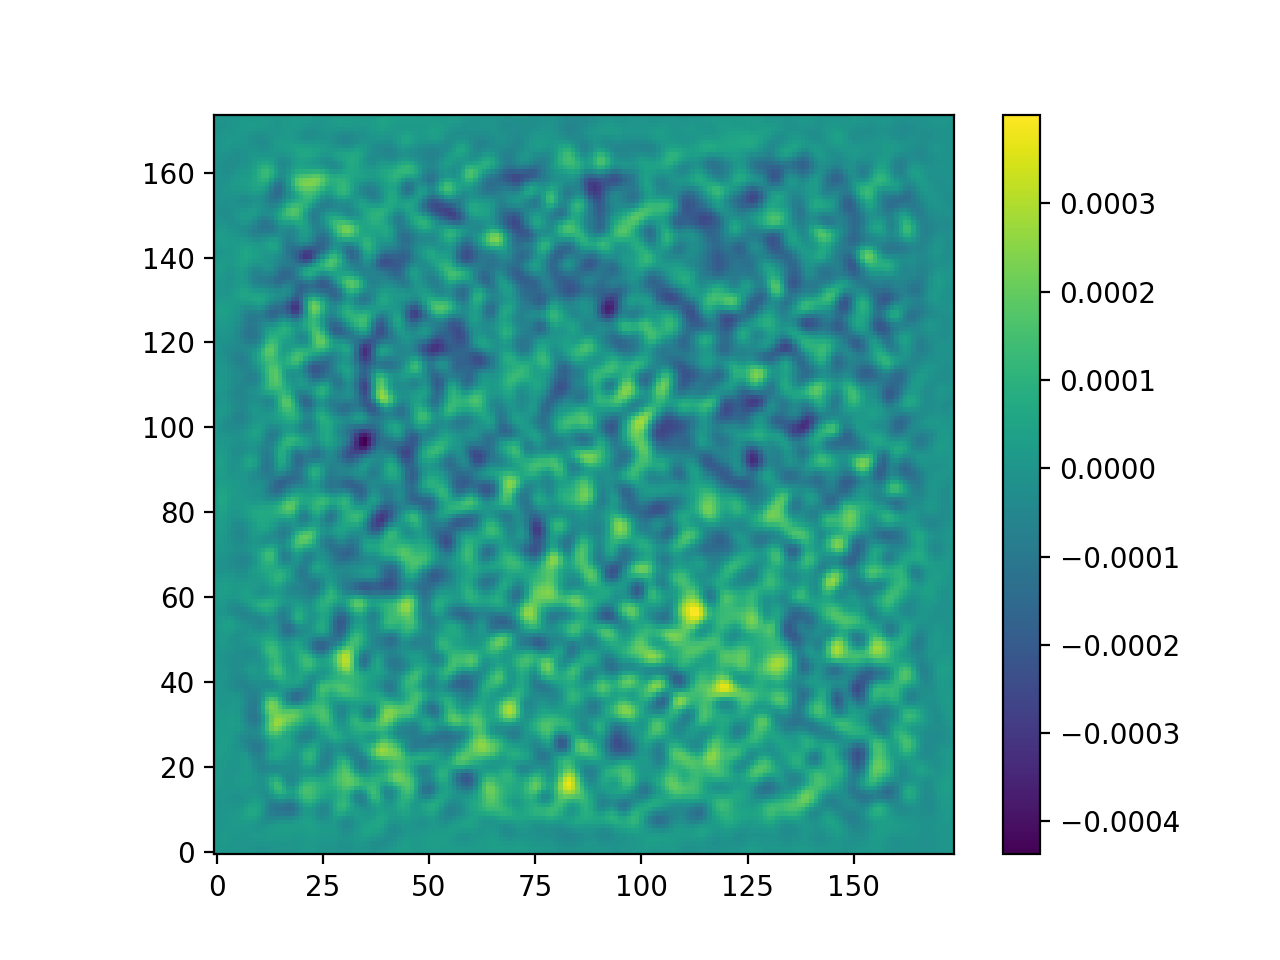

<IPython.core.display.Javascript object>


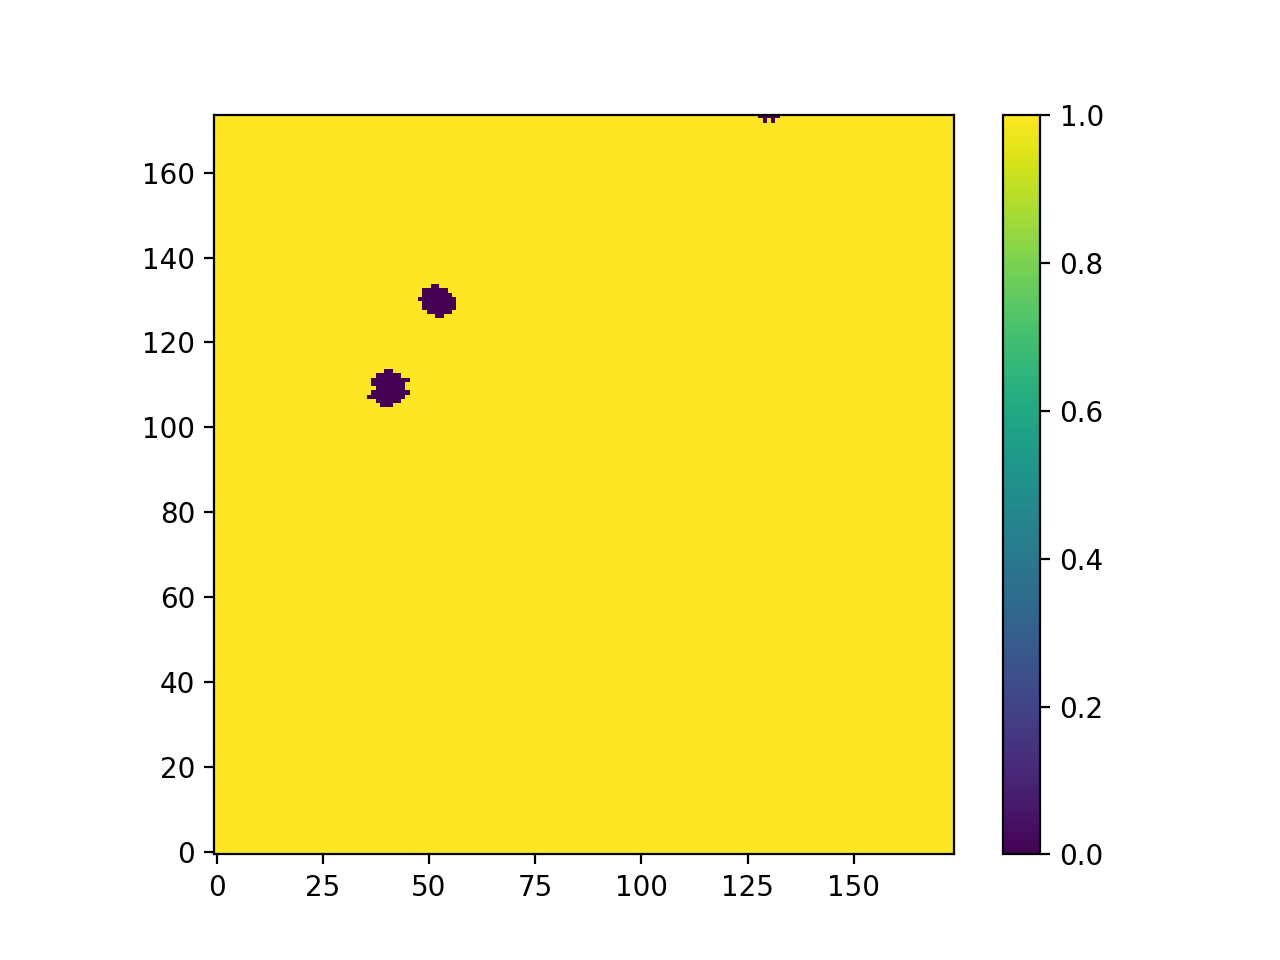

In [1195]:
figure()
imshow(data_sz,origin="lower")
colorbar()

figure()
imshow(yc,origin="lower")
colorbar()

figure()
imshow((data_sz-yc)/err,origin="lower")
colorbar()

figure()
imshow(data_cmb,origin="lower")
colorbar()

figure()
imshow(psmask,origin="lower")
colorbar()

In [1165]:
res,err=op.evaluate_mmf(op.sp_ft_bank[18.0],tmplt.sz_spec_bank[0.])

<IPython.core.display.Javascript object>


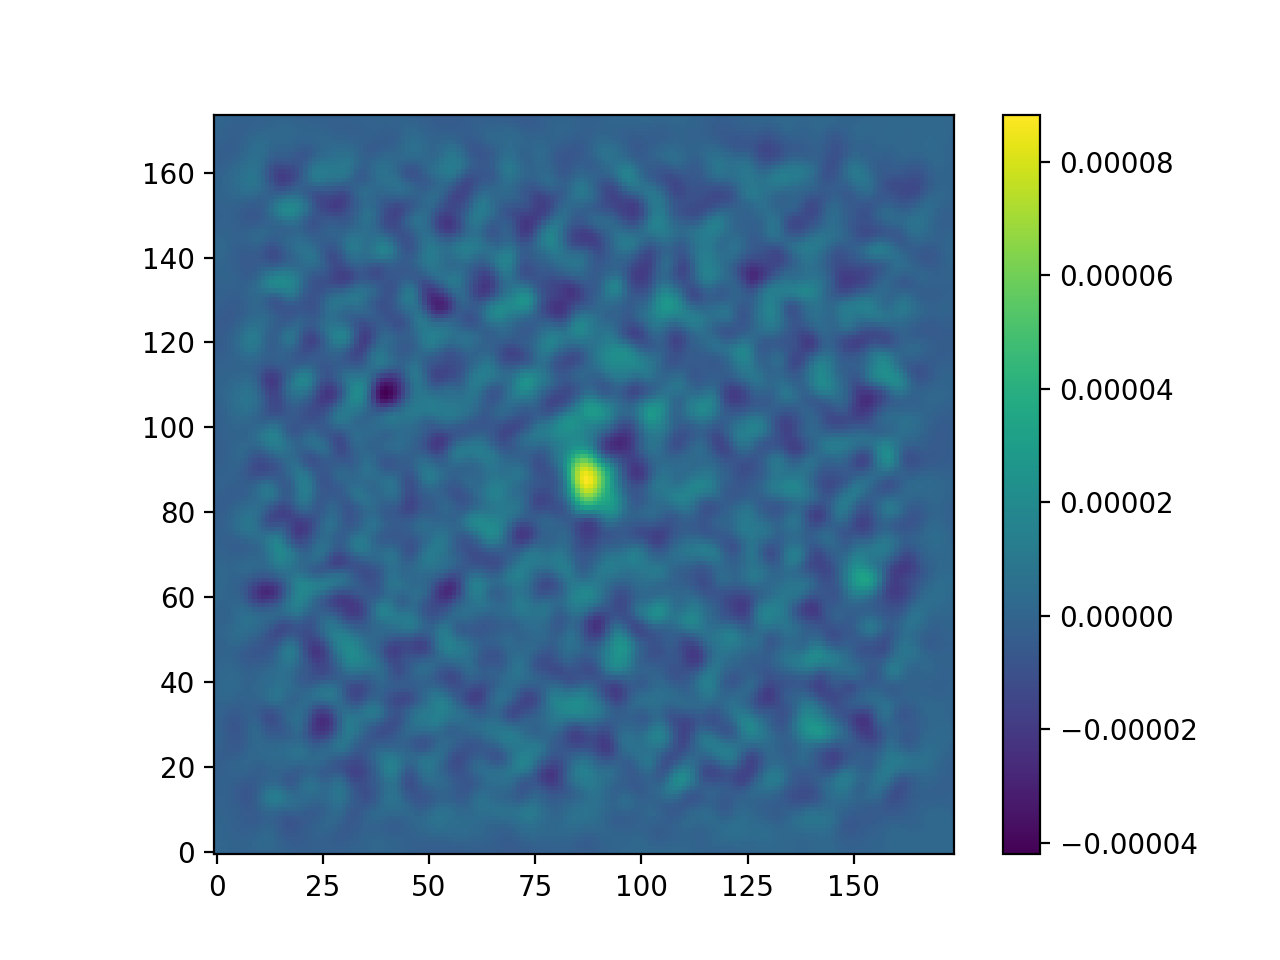

<IPython.core.display.Javascript object>


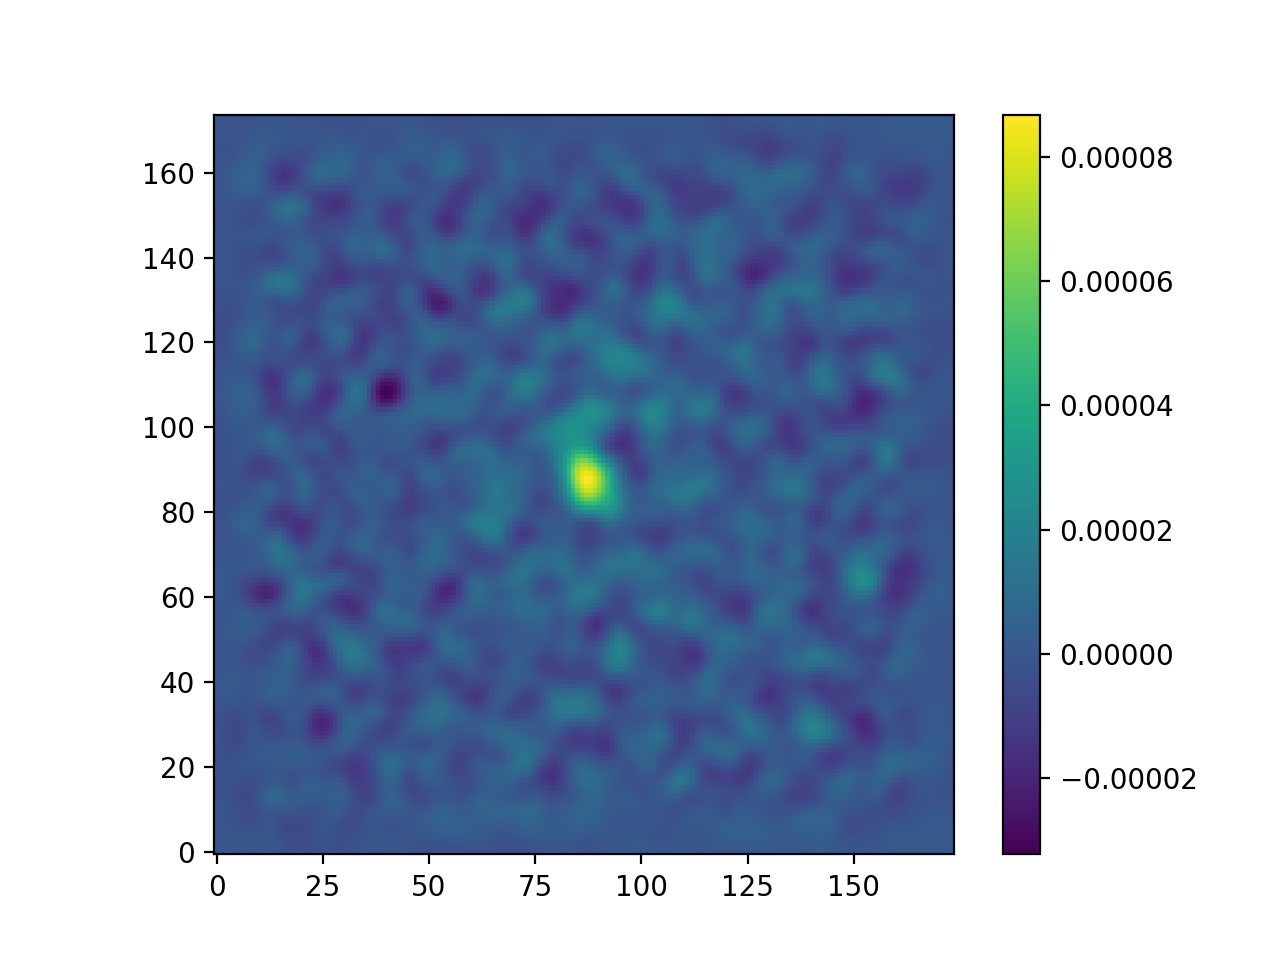

In [1166]:
figure()
imshow(res,origin="lower")
colorbar() 

figure()
imshow(yc,origin="lower")
colorbar()

# Solving for the moments for spectral distortion signal

In [383]:
np.random.seed(0)
cl=h.read_cl("/Users/adityarotti/Documents/Work/Data/Planck/spectra/planck_wp_highL_lensing_param.fits")
cmb=fsa.gensim(cl[0][2:],op.nxpix,gset.mmfset.reso)*1e-6
cmbe=fsa.gensim(cl[1][2:],op.nxpix,gset.mmfset.reso)
amp_tnu=1e-9
nvar=1e-6
tnu=np.zeros(op.numch)
data=np.zeros(psf_data.shape,np.float64)
for ich,ch in enumerate(gset.mmfset.channels):
    tnu[ich]=ch**3./(1e6)
#     data[ich,:,:]=data[ich,:,:] + 1e-9*tnu[ich] 
    data[ich,:,:]=data[ich,:,:] + cmb + ymap_cilc*snu[ich]*emask + amp_tnu*cmbe*tnu[ich]  + np.random.normal(0,nvar,(op.nxpix,op.nxpix))
op.get_data_ft(data,smwin=5)
data_ft=np.zeros(op.data_ft.shape,complex)

In [388]:
ellp,smbl=fsa.get_gauss_beam(5.,lmax=lmax)
smfiltr=fsa.get_fourier_filter(smbl,gset.mmfset.npix,gset.mmfset.reso,ell=ellp)

for i in range(op.numch):
    data_ft[i,:,:]=op.data_ft[i,:,:]*smfiltr

cross_Pk=np.zeros((op.totnpix,op.numch,op.numch),np.float64)
for i,ch in enumerate(gset.mmfset.channels):
    for j in range(i+1):
        ell,cl=fsa.alm2cl(alm=data_ft[i,],almp=data_ft[j,],pixel_size=gset.mmfset.reso,smwin=5)
        filtr=fsa.get_fourier_filter(cl,op.nxpix,gset.mmfset.reso,ell=ell)
        cross_Pk[:,i,j]=filtr.reshape(op.totnpix)
        cross_Pk[:,j,i]=cross_Pk[:,i,j]
cross_Pk_inv=np.linalg.inv(cross_Pk)

In [389]:
V=np.array([tnu,snu,np.ones(op.numch)])
V=np.array([tnu,snu])
e=np.zeros(V.shape[0]) ; e[0]=1.

temp_fdata_ft=data_ft.reshape(op.numch,op.totnpix)
C=np.einsum("qi,kij,nj->kqn",V,cross_Pk_inv,V)
Cinv=np.linalg.inv(C)
fil_fdata=np.einsum("qi,kij,jk->qk",V,cross_Pk_inv,temp_fdata_ft)
comp=["tnu","sz","cmb"] ; rec_fdata={} ; rec_data={}
dft=(np.einsum("kij,jk->ki",Cinv,fil_fdata)).reshape(op.nxpix,op.nxpix,V.shape[0])

for i,cmp in enumerate(comp):
    rec_fdata[cmp]=dft[:,:,i]*smfiltr
    rec_data[cmp]=fsa.alm2map(rec_fdata[cmp],gset.mmfset.reso)

noise per pixel : 1e-06
number of pixels: 30276
injected: 1e-09
recovered: 4.86046867135e-09
snr: 1.00286294785
bias: -0.796532444426


<IPython.core.display.Javascript object>


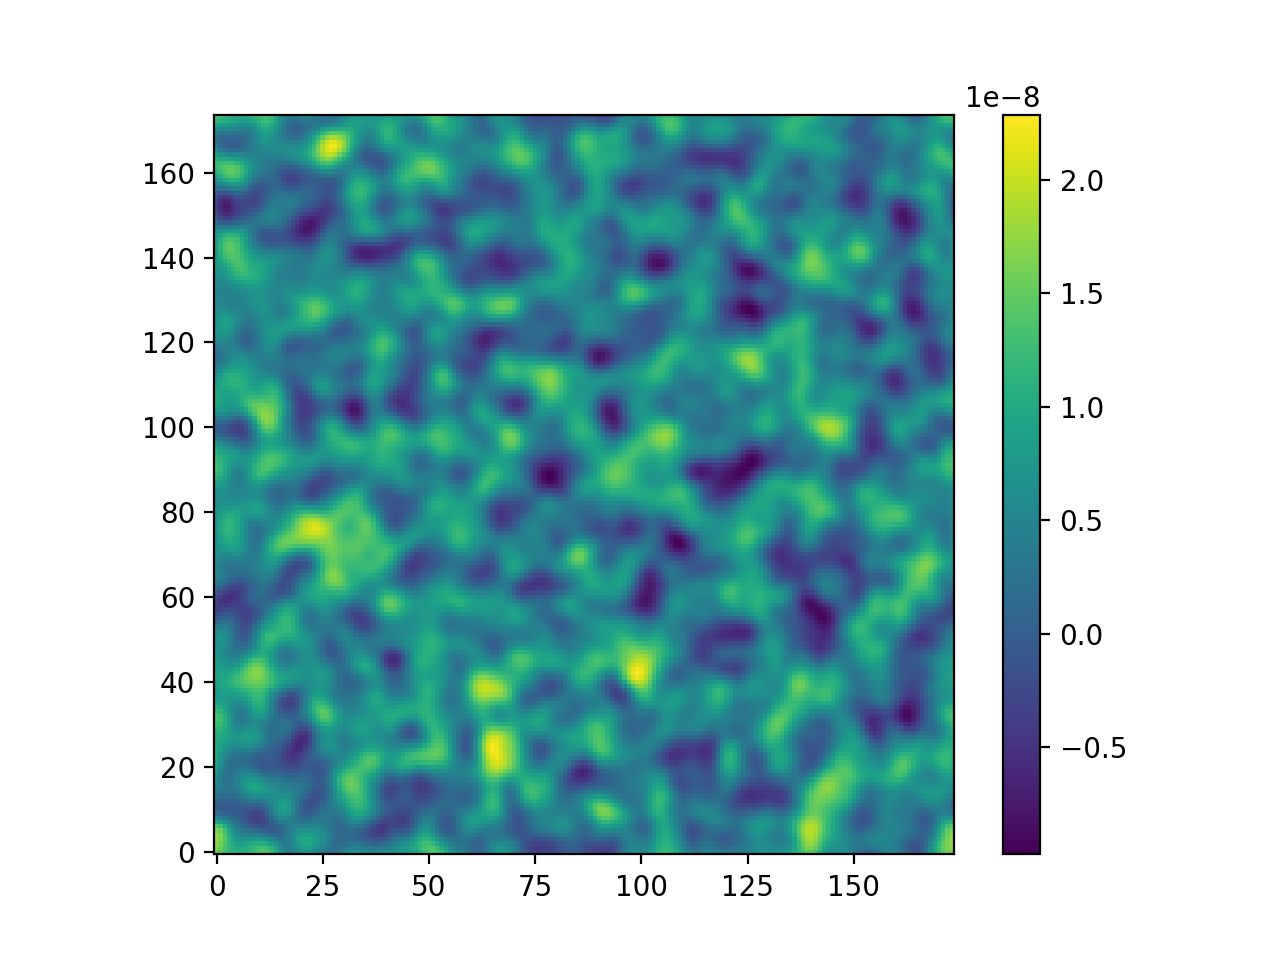

<IPython.core.display.Javascript object>


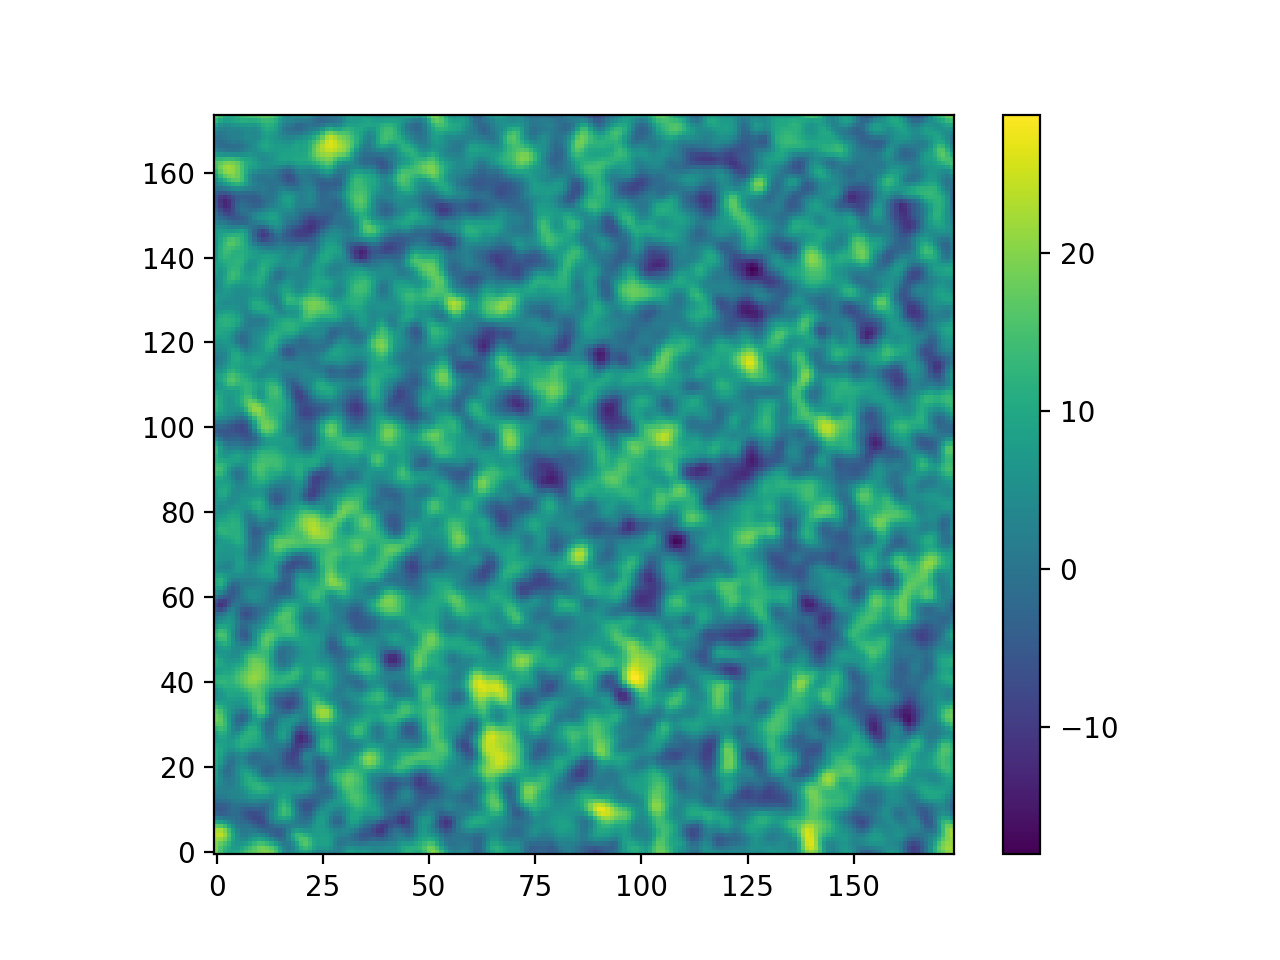

<IPython.core.display.Javascript object>


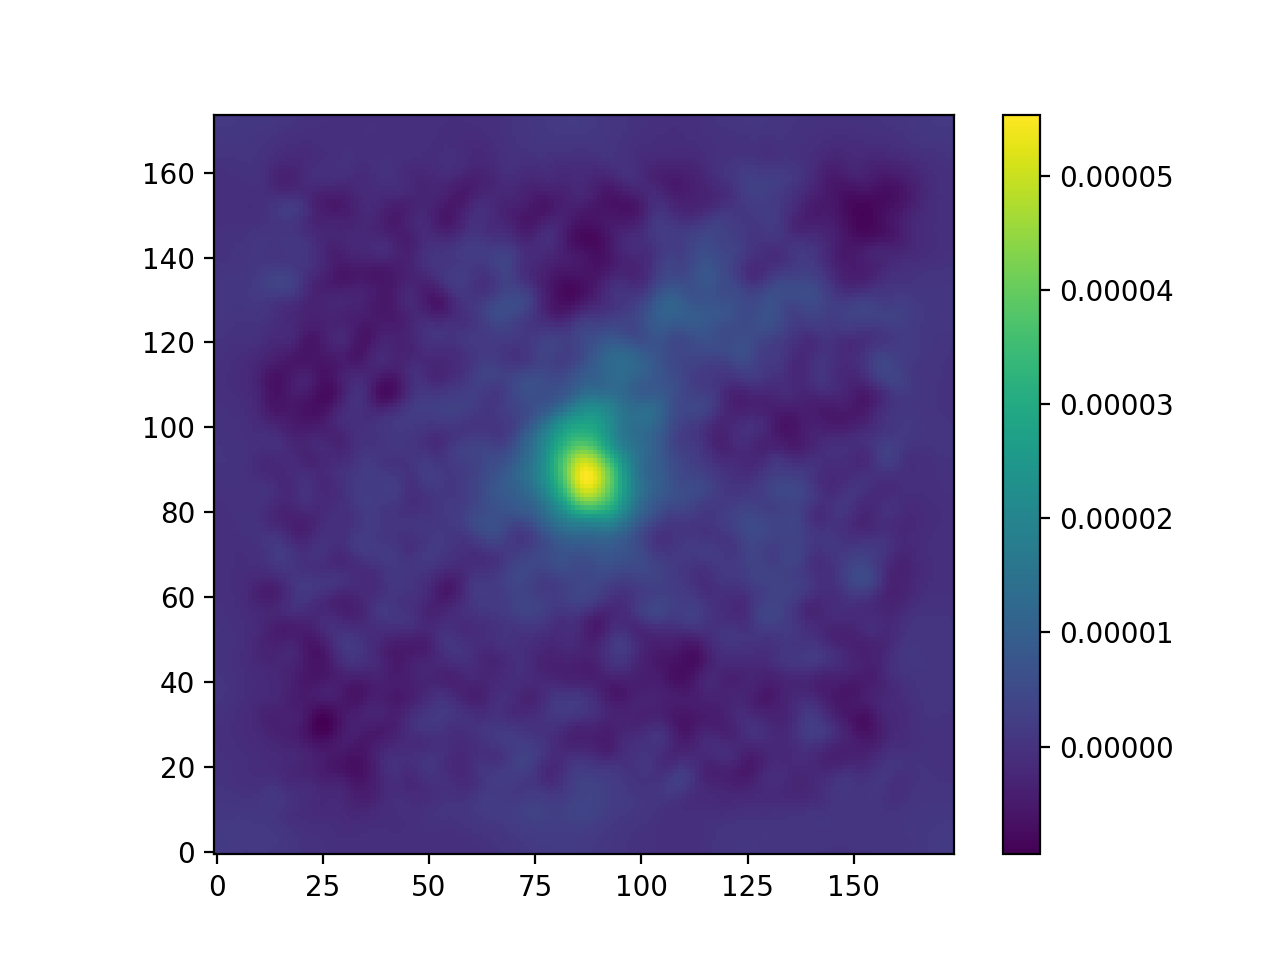

<IPython.core.display.Javascript object>


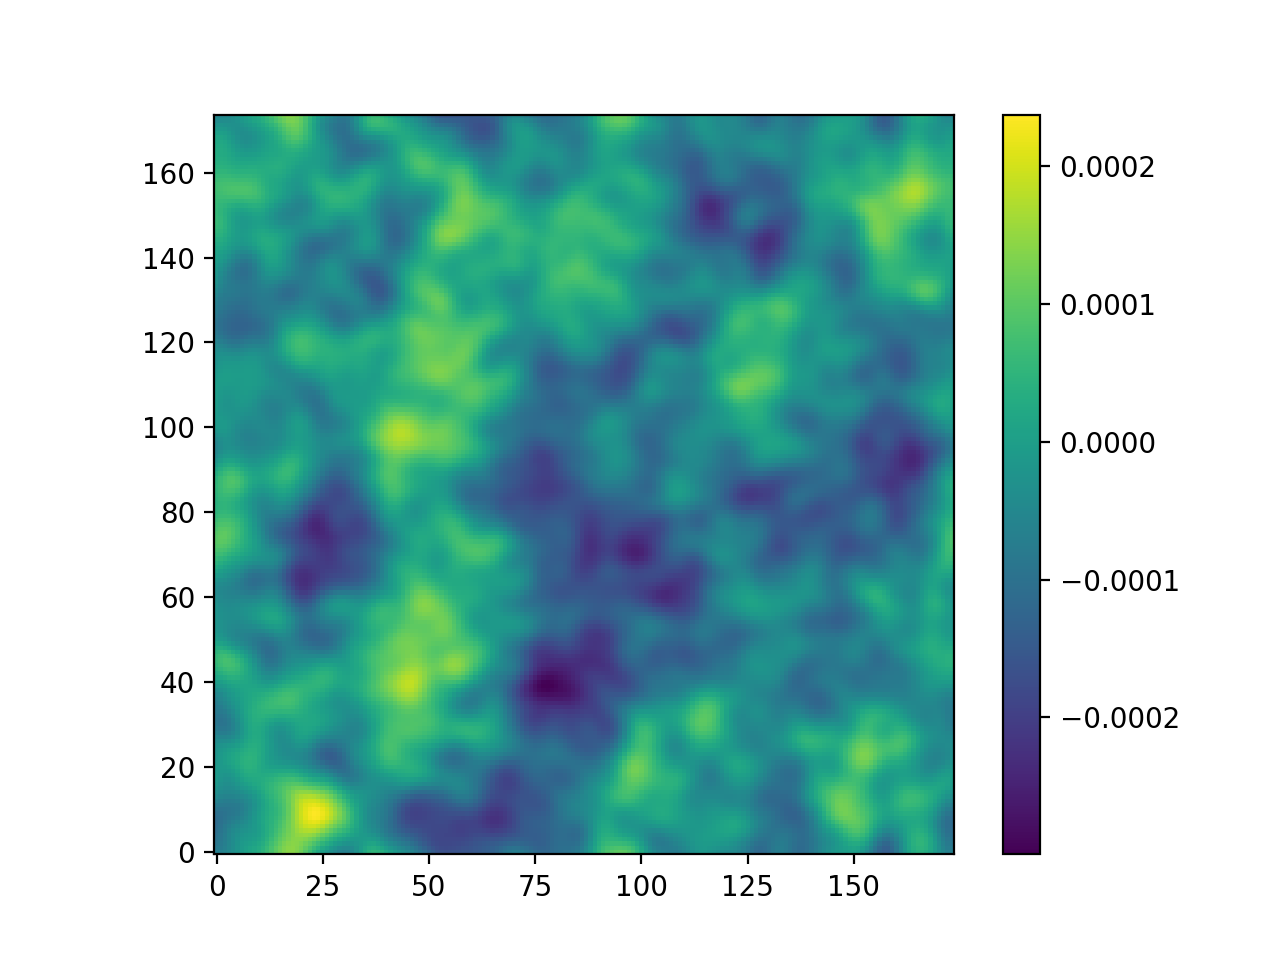

In [390]:
print "noise per pixel :",nvar
print "number of pixels:", op.nxpix**2
print "injected:", amp_tnu
print "recovered:", np.mean(rec_data["tnu"])
print "snr:", (np.mean(rec_data["tnu"]))/np.sqrt(np.var(rec_data["tnu"]))
print "bias:", (amp_tnu-np.mean(rec_data["tnu"]))/np.sqrt(np.var(rec_data["tnu"]))

figure()
imshow(rec_data["tnu"],origin="lower")
colorbar()

figure()
imshow(cmbe,origin="lower")
colorbar()


figure()
imshow(rec_data["sz"] ,origin="lower")
colorbar()

figure()
imshow(rec_data["cmb"] ,origin="lower")
colorbar()

<IPython.core.display.Javascript object>


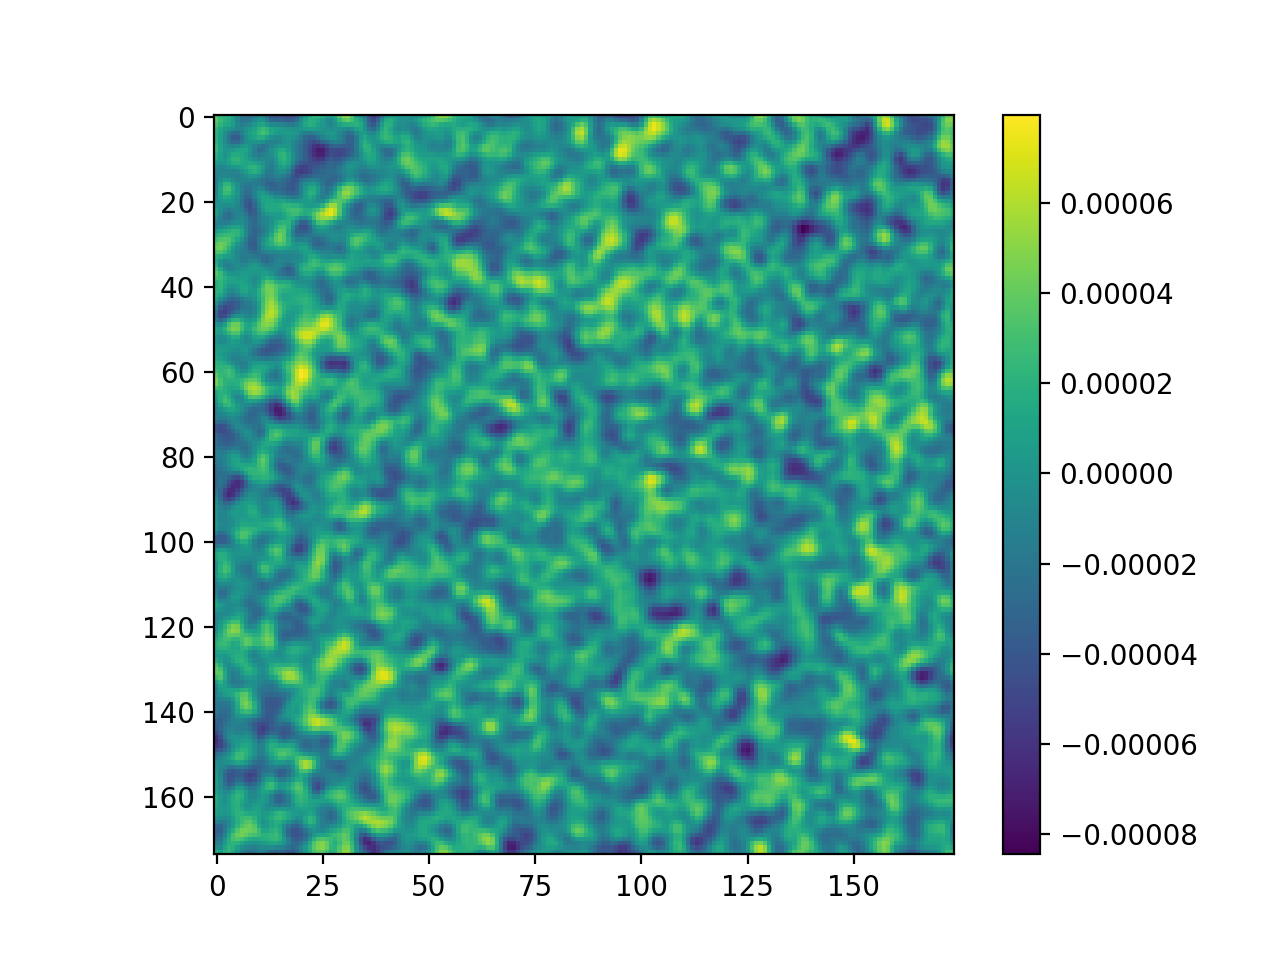

In [356]:
figure()
imshow(rec_data["cmb"]-cmb)
colorbar()